In [1]:
import numpy as np

train_x = np.load('data/x_train.npz')['arr_0']
test_x = np.load('data/x_test.npz')['arr_0']
train_y = np.load('data/y_train.npz')['arr_0']
test_y = np.load('data/y_test.npz')['arr_0']

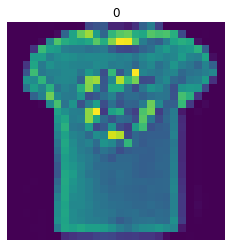

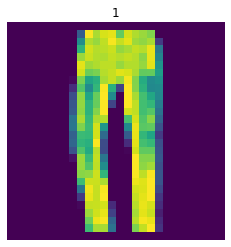

In [2]:
import matplotlib.pyplot as plt

def show_img(X, title: str = ''):
    plt.imshow(X)
    plt.axis('off')
    plt.title(f'{title}')
    plt.show()

index = 0
show_img(train_x[index], str(train_y[index]))
index = 1003
show_img(train_x[index], str(train_y[index]))

In [3]:
train_x = train_x.reshape(train_x.shape[0], -1)
test_x = test_x.reshape(test_x.shape[0], -1)

### Activation functions

1. Identity AF

In [4]:
def identity(x):
    return x

2. Sigmoid

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

3. Tanh 

In [6]:
def tanh(x):
    return (2 * sigmoid(2*x)) - 1

4. Relu

In [7]:
def relu(x):
    return np.maximum(0, x)

5. Leaky relu

In [8]:
def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha*x, x)

### Initial weights

1. Zero

In [9]:
def zero_init(t1, t2=1):
    """
    Parameters:
    - t1 (int): Number of neurons in the current layer.
    - t2 (int): Number of neurons in the next layer.
    """
    return np.zeros((t1, t2))

2. Random

In [47]:
def random_init_s(t1, t2=1, std_dev=0.01):
    return np.random.normal(0, std_dev, size=(t1, t2))

In [48]:
def random_init_l(t1, t2=1, std_dev=1.0):
    return np.random.normal(0, std_dev, size=(t1, t2))

3. Xavier

In [12]:
def xavier_init(t1, t2=1):
    return np.random.randn(t1, t2) * np.sqrt(1/ t1)

4. He

In [13]:
def he_init(t1, t2=1):
    std_dev = 2/t1
    return np.random.normal(0, std_dev, size=(t1, t2))

In [14]:
def binary_cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-15  # to prevent log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # clip values to avoid log(0) or log(1)

    # Binary Cross Entropy Loss
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    return loss

In [15]:
# Calculate the derivative of BCE with respect to prediction (y_pred)
def bce_derivative(y_true, y_pred):
    # y_true_expanded = np.expand_dims(y_true, axis=1)
    epsilon = 1e-15  # Add a small epsilon to avoid division by zero
    return (y_pred - y_true) / (y_pred * (1 - y_pred) + epsilon)

In [16]:
def identity_derivative(x):
    return np.ones_like(x)

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def relu_derivative(x):
    return np.where(x <= 0, 0, 1)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x <= 0, alpha, 1)


In [17]:
def mlp(l, t, n, p, f, init):
    # l is a scalar for the number of layers
    # t is a list of size l that each item indicates the number of neurons in each layer
    # n is the number of features of input
    # p is the number of patterns
    # f is a list of size l that each item indicates the activation function of each layer
    # init is the way that we initialize weights

    t2 = [n] + t  # Add input layer size to the beginning of the list

    # Initialize weights using Xavier initialization
    if(init=='zero'):
        weights = [zero_init(t2[i], t2[i+1]) for i in range(l)]
        biases = [zero_init(t2[i+1]) for i in range(l)]
    elif(init=='rand_s'):
        weights = [random_init_s(t2[i], t2[i+1]) for i in range(l)]
        biases = [random_init_s(t2[i+1]) for i in range(l)]       
    elif(init=='rand_l'):
        weights = [random_init_l(t2[i], t2[i+1]) for i in range(l)]
        biases = [random_init_l(t2[i+1]) for i in range(l)] 
    elif(init=='xavier'):
        weights = [xavier_init(t2[i], t2[i+1]) for i in range(l)]
        biases = [xavier_init(t2[i+1]) for i in range(l)]     
    elif(init=='he'):
        weights = [he_init(t2[i], t2[i+1]) for i in range(l)]
        biases = [he_init(t2[i+1]) for i in range(l)] 

    model = {
        "l": l,
        "t": t,
        "n": n,
        "p": p,
        "f": f,
        "weights": weights,
        "biases": biases
    }

    return model

In [18]:
def forward(model, datas, y_trues):
    l = model["l"]
    t = model["t"]
    n = model["n"]
    p = model["p"]
    f = model["f"]
    weights = model["final_weights"]
    biases = model["final_biases"]

    count = 0

    for j in range(datas.shape[1]):
            data = datas[j]
            y_true = y_trues[j]

            dict = {}

            dict["a0"] = data

            # Calculate sigma w*x + b for each layer
            layer_outputs = [data] # Initial layer is the input data

            for i in range(1, l+1):  # Iterate over layers
                # Calculate the weighted sum (sigma w*x + b)
                weighted_sum = np.zeros(np.shape(biases[i-1]))
                for k in range(len(biases[i-1])):
                    weighted_sum[k] = np.dot(weights[i-1].T,layer_outputs[-1])[k] + biases[i-1][k]

                dict["z" + str(i)] = weighted_sum

                # Apply activation function
                if f[i-1] == 'identity':
                    layer_output = identity(weighted_sum)                
                elif f[i-1] == 'sigmoid':
                    layer_output = sigmoid(weighted_sum)
                elif f[i-1] == 'tanh':
                    layer_output = tanh(weighted_sum)                    
                elif f[i-1] == 'relu':
                    layer_output = relu(weighted_sum)
                elif f[i-1] == 'leaky_relu':
                    layer_output = leaky_relu(weighted_sum)    

                dict["a"+str(i)] = layer_output
                # Append the layer output to the list
                layer_outputs.append(layer_output)

            y_pred = dict["a"+str(len(t))]
            loss = binary_cross_entropy_loss(y_true, y_pred)

            y = predict(y_pred)

            if(y == y_true):
                count+=1
    acc = count/len(y_trues)
    
    if(acc<0.5):
        acc = 1 - acc

    return loss, acc

In [19]:
def predict(y):
    y_pred = []
    for i in range(len(y)):
        if (y>0.5):
            y_pred.append(1)
        else:
            y_pred.append(0)
    return y_pred

In [20]:
#simple with no batch
def backpropagation(model, epochs, datas, y_trues, learning_rate, test_x, test_y):
    l = model["l"]
    t = model["t"]
    n = model["n"]
    p = model["p"]
    f = model["f"]
    weights = model["weights"]
    biases = model["biases"]

    losses = []
    losses_test = []
    acc = []
    acc_test = []

    for epoch in range(epochs):
        for j in range(datas.shape[1]):
            data = datas[j]
            y_true = y_trues[j]

            dict = {}      

            a = np.zeros((len(data),1))
            for k in range(len(data)):
                a[k][0] = data[k]
            dict["a0"] = a


            # Calculate sigma w*x + b for each layer
            layer_outputs = [data] # Initial layer is the input data

            for i in range(1, l+1):  # Iterate over layers
                # Calculate the weighted sum (sigma w*x + b)
                weighted_sum = np.zeros(np.shape(biases[i-1]))
                for k in range(len(biases[i-1])):
                    weighted_sum[k] = np.dot(weights[i-1].T,layer_outputs[-1])[k] + biases[i-1][k]

                dict["z" + str(i)] = weighted_sum

                # Apply activation function
                if f[i-1] == 'identity':
                    layer_output = identity(weighted_sum)                
                elif f[i-1] == 'sigmoid':
                    layer_output = sigmoid(weighted_sum)
                elif f[i-1] == 'tanh':
                    layer_output = tanh(weighted_sum)                    
                elif f[i-1] == 'relu':
                    layer_output = relu(weighted_sum)
                elif f[i-1] == 'leaky_relu':
                    layer_output = leaky_relu(weighted_sum)                    

                dict["a"+str(i)] = layer_output
                # Append the layer output to the list
                layer_outputs.append(layer_output)

            y_pred = dict["a"+str(len(t))]
            loss = binary_cross_entropy_loss(y_true, y_pred)

            if j % 500 == 0:
                if epoch %10 ==0:
                    print(f"Epoch {epoch}, data{j}, Loss: {loss}")

            # Initialize gradients for weights and biases
            grad_weights = [np.zeros_like(weight) for weight in weights]
            grad_biases = [np.zeros_like(bias) for bias in biases]

            # Backward pass
            for i in range(l, 0, -1):
                # Derivative of the loss with respect to the weighted sum (z)
                d_loss_da = bce_derivative(y_true, dict["a" + str(i)])

                # Derivative of the weighted sum (z) with respect to the activation (a)             
                if f[i-1] == 'identity':
                    d_a_dz = identity_derivative(dict["z" + str(i)])                
                elif f[i-1] == 'sigmoid':
                    d_a_dz = sigmoid_derivative(dict["z" + str(i)])
                elif f[i-1] == 'tanh':
                    d_a_dz = tanh_derivative(dict["z" + str(i)])                   
                elif f[i-1] == 'relu':
                    d_a_dz = relu_derivative(dict["z" + str(i)])
                elif f[i-1] == 'leaky_relu':
                    d_a_dz = leaky_relu_derivative(dict["z" + str(i)])                   

                # Derivative of the activation (a) with respect to the weighted sum (z)
                d_loss_dz = np.zeros((len(d_loss_da),1))
                for k in range (len(d_loss_da)):  
#                     print(len(d_loss_da))
                    d_loss_dz[k][0] = d_loss_da[k] * d_a_dz[k]

                # Derivative of the weighted sum (z) with respect to the weights and biases
                d_loss_dw = np.dot(dict["a" + str(i-1)], d_loss_dz.T)              
                d_loss_db = d_loss_dz

                # Chain rule to calculate gradients
                grad_weights[i-1] = d_loss_dw
                grad_biases[i-1] = d_loss_db

            # Update weights and biases using gradient descent
            for i in range(l):
                for k in range(len(weights[i])):
                    weights[i][k] -= learning_rate * grad_weights[i][k]
                biases[i] -= learning_rate * grad_biases[i][0]
        
        model["final_weights"] = weights
        model["final_biases"] = biases
        
        loss , accuracy = forward(model, datas, y_trues)
        losses.append(loss)
        acc.append(accuracy)
        
        loss , accuracy = forward(model, test_x, test_y)
        losses_test.append(loss)
        acc_test.append(accuracy)
        

    model["final_weights"] = weights
    model["final_biases"] = biases
    model["losses"] = losses
    model["acc"] = acc
    model["losses_test"] = losses_test
    model["acc_test"] = acc_test
    return model

In [21]:
def backprop(model, epochs, datas, y_trues, learning_rate, test_x, test_y, batch=1):
    l = model["l"]
    t = model["t"]
    n = model["n"]
    p = model["p"]
    f = model["f"]
    weights = model["weights"]
    biases = model["biases"]

    losses = []
    losses_test = []
    acc = []
    acc_test = []

    for epoch in range(epochs):
        for j in range(datas.shape[1]):
            data = datas[j:j+batch]
            y_true = y_trues[j:batch]
            j += batch

            dict = {}

            a = np.zeros((len(data),1))
            for k in range(len(data)):
                a[k][0] = data[k]
            dict["a0"] = a

            # Calculate sigma w*x + b for each layer
            layer_outputs = [data] # Initial layer is the input data

            for i in range(1, l+1):  # Iterate over layers
                # Calculate the weighted sum (sigma w*x + b)
                weighted_sum = np.zeros(np.shape(biases[i-1]))
                for k in range(len(biases[i-1])):
                    weighted_sum[k] = np.dot(weights[i-1].T,layer_outputs[-1])[k] + biases[i-1][k]

                dict["z" + str(i)] = weighted_sum

                # Apply activation function
                if f[i-1] == 'identity':
                    layer_output = identity(weighted_sum)                
                elif f[i-1] == 'sigmoid':
                    layer_output = sigmoid(weighted_sum)
                elif f[i-1] == 'tanh':
                    layer_output = tanh(weighted_sum)                    
                elif f[i-1] == 'relu':
                    layer_output = relu(weighted_sum)
                elif f[i-1] == 'leaky_relu':
                    layer_output = leaky_relu(weighted_sum)                    

                dict["a"+str(i)] = layer_output
                # Append the layer output to the list
                layer_outputs.append(layer_output)

            y_pred = dict["a3"]
            loss = binary_cross_entropy_loss(y_true, y_pred)

            if j % 500 == 0:
                if epoch %10 ==0:
                    print(f"Epoch {epoch}, data{j}, Loss: {loss}")

            # Initialize gradients for weights and biases
            grad_weights = [np.zeros_like(weight) for weight in weights]
            grad_biases = [np.zeros_like(bias) for bias in biases]

            # Backward pass
            for i in range(l, 0, -1):
                # Derivative of the loss with respect to the weighted sum (z)
                d_loss_da = bce_derivative(y_true, dict["a" + str(i)])

                # Derivative of the weighted sum (z) with respect to the activation (a)             
                if f[i-1] == 'identity':
                    d_a_dz = identity_derivative(dict["z" + str(i)])                
                elif f[i-1] == 'sigmoid':
                    d_a_dz = sigmoid_derivative(dict["z" + str(i)])
                elif f[i-1] == 'tanh':
                    d_a_dz = tanh_derivative(dict["z" + str(i)])                   
                elif f[i-1] == 'relu':
                    d_a_dz = relu_derivative(dict["z" + str(i)])
                elif f[i-1] == 'leaky_relu':
                    d_a_dz = leaky_relu_derivative(dict["z" + str(i)])                   

                # Derivative of the activation (a) with respect to the weighted sum (z)
                d_loss_dz = np.zeros((len(d_loss_da),1))
                for k in range (len(d_loss_da)):  
                    d_loss_dz[k][0] = d_loss_da[k] * d_a_dz[k]

                # Derivative of the weighted sum (z) with respect to the weights and biases
                d_loss_dw = np.dot(dict["a" + str(i-1)], d_loss_dz.T)              
                d_loss_db = d_loss_dz
                
                if(model["moving_average"].exist):
                    

                # Chain rule to calculate gradients
                grad_weights[i-1] = d_loss_dw
                grad_biases[i-1] = d_loss_db

            # Update weights and biases using gradient descent
            for i in range(l):
                for k in range(len(weights[i])):
                    weights[i][k] -= learning_rate * grad_weights[i][k]
                biases[i] -= learning_rate * grad_biases[i][0]
        
        model["final_weights"] = weights
        model["final_biases"] = biases
        
        loss , accuracy = forward(model, datas, y_trues)
        losses.append(loss)
        acc.append(accuracy)
        
        loss , accuracy = forward(model, test_x, test_y)
        losses_test.append(loss)
        acc_test.append(accuracy)
        

    model["final_weights"] = weights
    model["final_biases"] = biases
    model["losses"] = losses
    model["acc"] = acc
    model["losses_test"] = losses_test
    model["acc_test"] = acc_test
    return model

IndentationError: expected an indented block (<ipython-input-21-92ae23c8376b>, line 96)

In [66]:
def backprop(model, epochs, datas, y_trues, learning_rate, test_x, test_y, batch=2):
    l = model["l"]
    t = model["t"]
    n = model["n"]
    p = model["p"]
    f = model["f"]
    weights = model["weights"]
    biases = model["biases"]

    losses = []
    losses_test = []
    acc = []
    acc_test = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        epoch_loss_test = 0
        epoch_accuracy_test = 0
        
        for j in range(0, datas.shape[1], batch):
            data_batch = datas[:, j:j+batch]
            y_true_batch = y_trues[j:j+batch]

            dict = {}
            dict["a0"] = data_batch

            # Forward pass
            layer_outputs = [data_batch] # Initial layer is the input data
            for i in range(1, l+1):
                weighted_sum = np.dot(weights[i-1].T, layer_outputs[-1]) + biases[i-1]
                dict["z" + str(i)] = weighted_sum

                # Apply activation function
                if f[i-1] == 'identity':
                    layer_output = identity(weighted_sum)                
                elif f[i-1] == 'sigmoid':
                    layer_output = sigmoid(weighted_sum)
                elif f[i-1] == 'tanh':
                    layer_output = tanh(weighted_sum)                    
                elif f[i-1] == 'relu':
                    layer_output = relu(weighted_sum)
                elif f[i-1] == 'leaky_relu':
                    layer_output = leaky_relu(weighted_sum)                    

                dict["a"+str(i)] = layer_output
                layer_outputs.append(layer_output)

            y_pred = dict["a" + str(l)]
            loss = binary_cross_entropy_loss(y_true_batch, y_pred)
            epoch_loss += loss

            # Compute accuracy for the batch
            batch_accuracy = accuracy(y_true_batch, y_pred)
            epoch_accuracy += batch_accuracy

            # Backward pass
            grad_weights = [np.zeros_like(weight) for weight in weights]
            grad_biases = [np.zeros_like(bias) for bias in biases]
            delta = y_pred - y_true_batch

            for i in range(l, 0, -1):
                d_loss_da = bce_derivative(y_true_batch, dict["a" + str(i)])
                d_a_dz = relu_derivative(dict["z" + str(i)])

                d_loss_dz = delta * d_a_dz

                grad_weights[i-1] = np.dot(layer_outputs[i-1], d_loss_dz.T)
                grad_biases[i-1] = np.sum(d_loss_dz, axis=1, keepdims=True)

                delta = np.dot(weights[i-1], d_loss_dz)

            # Update weights and biases using gradient descent
            for i in range(l):
                weights[i] -= learning_rate * grad_weights[i]
                biases[i] -= learning_rate * grad_biases[i]

        # Calculate average loss and accuracy for the epoch
        epoch_loss /= datas.shape[1] // batch
        epoch_accuracy /= datas.shape[1] // batch
        losses.append(epoch_loss)
        acc.append(epoch_accuracy)

        # Compute loss and accuracy on test data
        test_loss, test_accuracy = forward(model, test_x, test_y)
        losses_test.append(test_loss)
        acc_test.append(test_accuracy)

        # Print progress
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}")

    model["final_weights"] = weights
    model["final_biases"] = biases
    model["losses"] = losses
    model["acc"] = acc
    model["losses_test"] = losses_test
    model["acc_test"] = acc_test

    return model


In [70]:
def backprop(model, epochs, datas, y_trues, learning_rate, test_x, test_y, batch=1):
    l = model["l"]
    t = model["t"]
    n = model["n"]
    p = model["p"]
    f = model["f"]
    weights = model["weights"]
    biases = model["biases"]

    losses = []
    losses_test = []
    acc = []
    acc_test = []
    
    j=0

    for epoch in range(epochs):
        while(j+batch <= datas.shape[1]):
            data = datas[j:j+batch]
            y_true = y_trues[j:j+batch]
            j += batch

            dict = {}      

            data = data.T
            dict["a0"] = data

            # Calculate sigma w*x + b for each layer
            layer_outputs = [data] # Initial layer is the input data

            for i in range(1, l+1):  # Iterate over layers
                # Calculate the weighted sum (sigma w*x + b)
                weighted_sum = np.zeros(np.shape(biases[i-1]))
                for k in range(len(biases[i-1])):
                    weighted_sum[k] = np.array(np.dot(weights[i-1].T,layer_outputs[-1])[k]) + np.array(biases[i-1][k])

                dict["z" + str(i)] = weighted_sum

                # Apply activation function
                if f[i-1] == 'identity':
                    layer_output = identity(weighted_sum)                
                elif f[i-1] == 'sigmoid':
                    layer_output = sigmoid(weighted_sum)
                elif f[i-1] == 'tanh':
                    layer_output = tanh(weighted_sum)                    
                elif f[i-1] == 'relu':
                    layer_output = relu(weighted_sum)
                elif f[i-1] == 'leaky_relu':
                    layer_output = leaky_relu(weighted_sum)                    

                dict["a"+str(i)] = layer_output
                # Append the layer output to the list
                layer_outputs.append(layer_output)

            y_pred = dict["a3"]
            loss = binary_cross_entropy_loss(y_true, y_pred)

            if j % 500 == 0:
                if epoch %10 ==0:
                    print(f"Epoch {epoch}, data{j}, Loss: {loss}")

            # Initialize gradients for weights and biases
            grad_weights = [np.zeros_like(weight) for weight in weights]
            grad_biases = [np.zeros_like(bias) for bias in biases]

            # Backward pass
            for i in range(l, 0, -1):
                # Derivative of the loss with respect to the weighted sum (z)
                d_loss_da = bce_derivative(y_true, dict["a" + str(i)])
                
#                 print(i,d_loss_da.shape)

                # Derivative of the weighted sum (z) with respect to the activation (a)             
                if f[i-1] == 'identity':
                    d_a_dz = identity_derivative(dict["z" + str(i)])                
                elif f[i-1] == 'sigmoid':
                    d_a_dz = sigmoid_derivative(dict["z" + str(i)])
                elif f[i-1] == 'tanh':
                    d_a_dz = tanh_derivative(dict["z" + str(i)])                   
                elif f[i-1] == 'relu':
                    d_a_dz = relu_derivative(dict["z" + str(i)])
                elif f[i-1] == 'leaky_relu':
                    d_a_dz = leaky_relu_derivative(dict["z" + str(i)])                   

                # Derivative of the activation (a) with respect to the weighted sum (z)
                d_loss_dz = np.zeros((len(d_loss_da),1))
                for k in range (len(d_loss_da)):  
                    d_loss_dz[k][0] = d_loss_da[k] * d_a_dz[k]

                # Derivative of the weighted sum (z) with respect to the weights and biases
                d_loss_dw = np.dot(dict["a" + str(i-1)], d_loss_dz.T)              
                d_loss_db = d_loss_dz

                # Chain rule to calculate gradients
                grad_weights[i-1] = d_loss_dw
                grad_biases[i-1] = d_loss_db

            # Update weights and biases using gradient descent
            for i in range(l):
                for k in range(len(weights[i])):
                    weights[i][k] -= learning_rate * grad_weights[i][k]
                biases[i] -= learning_rate * grad_biases[i][0]
        
        model["final_weights"] = weights
        model["final_biases"] = biases
        
        loss , accuracy = forward(model, datas, y_trues)
        losses.append(loss)
        acc.append(accuracy)
        
        loss , accuracy = forward(model, test_x, test_y)
        losses_test.append(loss)
        acc_test.append(accuracy)
        

    model["final_weights"] = weights
    model["final_biases"] = biases
    model["losses"] = losses
    model["acc"] = acc
    model["losses_test"] = losses_test
    model["acc_test"] = acc_test
    return model

In [86]:
def backprop(model, epochs, datas, y_trues, learning_rate, test_x, test_y, batch=2):
    l = model["l"]
    t = model["t"]
    n = model["n"]
    p = model["p"]
    f = model["f"]
    weights = model["weights"]
    biases = model["biases"]

    losses = []
    losses_test = []
    acc = []
    acc_test = []
    
    j=0

    for epoch in range(epochs):
        while(j+batch <= datas.shape[1]):
            data = datas[j:j+batch]
            y_true = y_trues[j:j+batch]
            j += batch

            dict = {}      

            data = data.T
            dict["a0"] = data

            # Calculate sigma w*x + b for each layer
            layer_outputs = [data] # Initial layer is the input data
            
            print(data.shape)

            for i in range(1, l+1):  # Iterate over layers
                # Calculate the weighted sum (sigma w*x + b)
                weighted_sum = np.zeros((biases[i-1].shape,batch))
                for k in range(len(biases[i-1])):
                    print(weights[i-1].shape)
                    print(biases[i-1].shape)
                    print(np.dot(weights[i-1].T,layer_outputs[-1]).shape)
                    
                    for m in range(len(np.dot(weights[i-1].T,layer_outputs[-1]).shape)):
                        
                        weighted_sum[k][m] = np.array(np.dot(weights[i-1].T,layer_outputs[-1])[k][m]) + np.array(biases[i-1][k])

                dict["z" + str(i)] = weighted_sum

                # Apply activation function
                if f[i-1] == 'identity':
                    layer_output = identity(weighted_sum)                
                elif f[i-1] == 'sigmoid':
                    layer_output = sigmoid(weighted_sum)
                elif f[i-1] == 'tanh':
                    layer_output = tanh(weighted_sum)                    
                elif f[i-1] == 'relu':
                    layer_output = relu(weighted_sum)
                elif f[i-1] == 'leaky_relu':
                    layer_output = leaky_relu(weighted_sum)                    

                dict["a"+str(i)] = layer_output
                # Append the layer output to the list
                layer_outputs.append(layer_output)

            y_pred = dict["a3"]
            loss = binary_cross_entropy_loss(y_true, y_pred)

            if j % 500 == 0:
                if epoch %10 ==0:
                    print(f"Epoch {epoch}, data{j}, Loss: {loss}")

            # Initialize gradients for weights and biases
            grad_weights = [np.zeros_like(weight) for weight in weights]
            grad_biases = [np.zeros_like(bias) for bias in biases]

            # Backward pass
            for i in range(l, 0, -1):
                # Derivative of the loss with respect to the weighted sum (z)
                d_loss_da = bce_derivative(y_true, dict["a" + str(i)])
                
#                 print(i,d_loss_da.shape)

                # Derivative of the weighted sum (z) with respect to the activation (a)             
                if f[i-1] == 'identity':
                    d_a_dz = identity_derivative(dict["z" + str(i)])                
                elif f[i-1] == 'sigmoid':
                    d_a_dz = sigmoid_derivative(dict["z" + str(i)])
                elif f[i-1] == 'tanh':
                    d_a_dz = tanh_derivative(dict["z" + str(i)])                   
                elif f[i-1] == 'relu':
                    d_a_dz = relu_derivative(dict["z" + str(i)])
                elif f[i-1] == 'leaky_relu':
                    d_a_dz = leaky_relu_derivative(dict["z" + str(i)])                   

                # Derivative of the activation (a) with respect to the weighted sum (z)
                d_loss_dz = np.zeros((len(d_loss_da),1))
                for k in range (len(d_loss_da)):  
                    d_loss_dz[k][0] = d_loss_da[k] * d_a_dz[k]

                # Derivative of the weighted sum (z) with respect to the weights and biases
                d_loss_dw = np.dot(dict["a" + str(i-1)], d_loss_dz.T)              
                d_loss_db = d_loss_dz

                # Chain rule to calculate gradients
                grad_weights[i-1] = d_loss_dw
                grad_biases[i-1] = d_loss_db

            # Update weights and biases using gradient descent
            for i in range(l):
                for k in range(len(weights[i])):
                    weights[i][k] -= learning_rate * grad_weights[i][k]
                biases[i] -= learning_rate * grad_biases[i][0]
        
        model["final_weights"] = weights
        model["final_biases"] = biases
        
        loss , accuracy = forward(model, datas, y_trues)
        losses.append(loss)
        acc.append(accuracy)
        
        loss , accuracy = forward(model, test_x, test_y)
        losses_test.append(loss)
        acc_test.append(accuracy)
        

    model["final_weights"] = weights
    model["final_biases"] = biases
    model["losses"] = losses
    model["acc"] = acc
    model["losses_test"] = losses_test
    model["acc_test"] = acc_test
    return model

In [84]:
datas = train_x
y_trues = train_y

l = 4
t = [16,8,4,1]
n = datas.shape[1]
p = datas.shape[0]
f = ['leaky_relu', 'relu', 'tanh', 'sigmoid']

learning_rate = 1
epochs = 5

model = mlp(l,t,n,p,f,'rand_s')

model = backprop(model, epochs, datas, y_trues, learning_rate, test_x, test_y)

loss , accuracy = forward(model, datas, y_trues)

print("train loss and accuracy")
print(loss, accuracy)

datas = test_x
y_trues = test_y

loss , accuracy = forward(model, datas, y_trues)

print("test loss and accuracy")
print(loss, accuracy)

plt.plot(range(epochs), model["losses"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training accuracy over Epochs')
plt.show()

plt.plot(range(epochs), model["losses_test"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc_test"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Test Accuracy over Epochs')
plt.show()

(784, 2)


TypeError: 'tuple' object cannot be interpreted as an integer

test 1.1

In [41]:
datas = train_x
y_trues = train_y

l = 4
t = [5,3,2,1]
n = datas.shape[1]
p = datas.shape[0]
f = ['relu', 'relu', 'relu', 'sigmoid']

learning_rate = 0.000000001
epochs = 40

model = mlp(l,t,n,p,f,'rand_s')

model = backpropagation(model, epochs, datas, y_trues, learning_rate, test_x, test_y)

loss , accuracy = forward(model, datas, y_trues)

print("train loss and accuracy")
print(loss, accuracy)

datas = test_x
y_trues = test_y

loss , accuracy = forward(model, datas, y_trues)

print("test loss and accuracy")
print(loss, accuracy)

plt.plot(range(epochs), model["losses"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training accuracy over Epochs')
plt.show()

plt.plot(range(epochs), model["losses_test"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc_test"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Test Accuracy over Epochs')
plt.show()

Epoch 0, data0, Loss: 0.6839066411838147
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5

1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3


5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2


2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3
5
5
5
5
5
1
2
2
3
3
3


KeyboardInterrupt: 

Epoch 0, data0, Loss: 0.0029104577509171917
Epoch 0, data500, Loss: 34.538776394910684
Epoch 10, data0, Loss: 9.992007221626415e-16
Epoch 10, data500, Loss: 34.538776394910684
train loss and accuracy
0.049408288632509324 0.9675
test loss and accuracy
0.049408288632509324 0.802


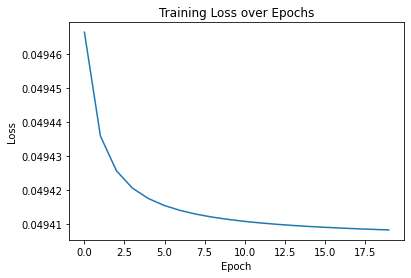

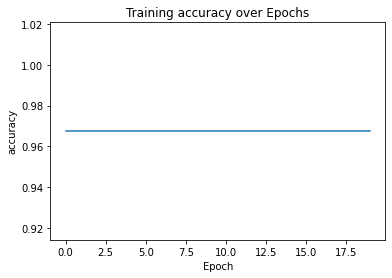

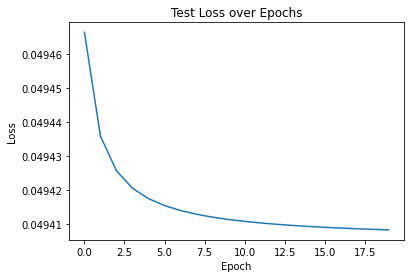

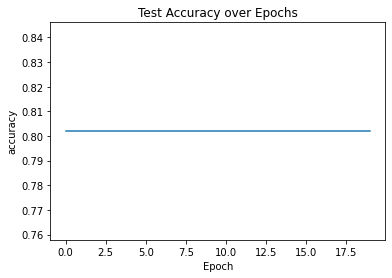

In [22]:
datas = train_x
y_trues = train_y

l = 4
t = [16,8,4,1]
n = datas.shape[1]
p = datas.shape[0]
f = ['leaky_relu', 'relu', 'tanh', 'sigmoid']

learning_rate = 1
epochs = 20

model = mlp(l,t,n,p,f,'rand_s')

model = backpropagation(model, epochs, datas, y_trues, learning_rate, test_x, test_y)

loss , accuracy = forward(model, datas, y_trues)

print("train loss and accuracy")
print(loss, accuracy)

datas = test_x
y_trues = test_y

loss , accuracy = forward(model, datas, y_trues)

print("test loss and accuracy")
print(loss, accuracy)

plt.plot(range(epochs), model["losses"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training accuracy over Epochs')
plt.show()

plt.plot(range(epochs), model["losses_test"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc_test"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Test Accuracy over Epochs')
plt.show()

In [ ]:
datas = train_x
y_trues = train_y

l = 4
t = [16,8,4,1]
n = datas.shape[1]
p = datas.shape[0]
f = ['leaky_relu', 'relu', 'tanh', 'sigmoid']

learning_rate = 1
epochs = 60

model = mlp(l,t,n,p,f,'rand_s')

model = backpropagation(model, epochs, datas, y_trues, learning_rate, test_x, test_y)

loss , accuracy = forward(model, datas, y_trues)

print("train loss and accuracy")
print(loss, accuracy)

datas = test_x
y_trues = test_y

loss , accuracy = forward(model, datas, y_trues)

print("test loss and accuracy")
print(loss, accuracy)

plt.plot(range(epochs), model["losses"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training accuracy over Epochs')
plt.show()

plt.plot(range(epochs), model["losses_test"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc_test"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Test Accuracy over Epochs')
plt.show()

Epoch 0, data0, Loss: 0.0055757768430184625
Epoch 0, data500, Loss: 30.727450637356228
Epoch 10, data0, Loss: 0.008614102517847897
Epoch 10, data500, Loss: 27.123038712435903
Epoch 20, data0, Loss: 0.011112441790746861
Epoch 20, data500, Loss: 30.650655695846268
Epoch 30, data0, Loss: 0.010245817145861954
Epoch 30, data500, Loss: 30.621533783061636
train loss and accuracy
0.6855293599427703 0.9675
test loss and accuracy
0.6858279069209411 0.802


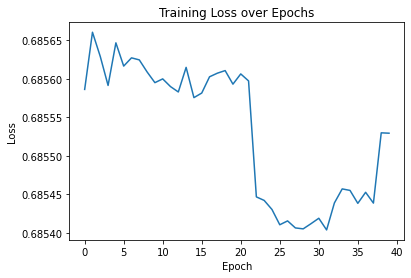

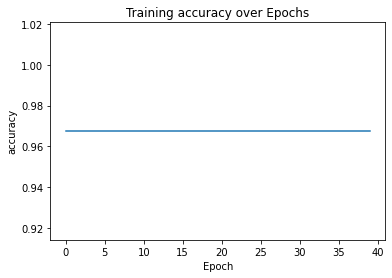

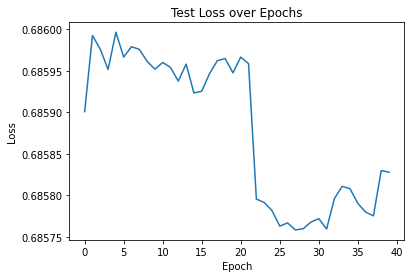

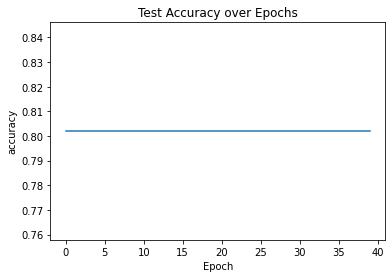

In [84]:
datas = train_x
y_trues = train_y

l = 4
t = [50,20,8,1]
n = datas.shape[1]
p = datas.shape[0]
f = ['leaky_relu', 'relu', 'tanh', 'sigmoid']

learning_rate = 0.000000001
epochs = 40

model = mlp(l,t,n,p,f,'rand_s')

model = backpropagation(model, epochs, datas, y_trues, learning_rate, test_x, test_y)

loss , accuracy = forward(model, datas, y_trues)

print("train loss and accuracy")
print(loss, accuracy)

datas = test_x
y_trues = test_y

loss , accuracy = forward(model, datas, y_trues)

print("test loss and accuracy")
print(loss, accuracy)

plt.plot(range(epochs), model["losses"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training accuracy over Epochs')
plt.show()

plt.plot(range(epochs), model["losses_test"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc_test"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Test Accuracy over Epochs')
plt.show()

Epoch 0, data0, Loss: 9.992007221626415e-16
Epoch 0, data500, Loss: 34.538776394910684
Epoch 10, data0, Loss: 9.992007221626415e-16
Epoch 10, data500, Loss: 34.538776394910684
Epoch 20, data0, Loss: 9.992007221626415e-16
Epoch 20, data500, Loss: 34.538776394910684
Epoch 30, data0, Loss: 9.992007221626415e-16
Epoch 30, data500, Loss: 34.538776394910684
train loss and accuracy
34.538776394910684 0.9671666666666666
test loss and accuracy
34.538776394910684 0.806


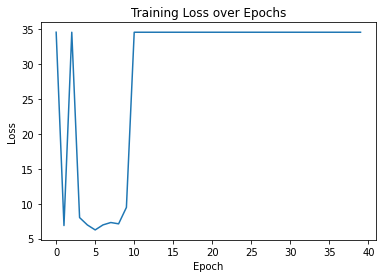

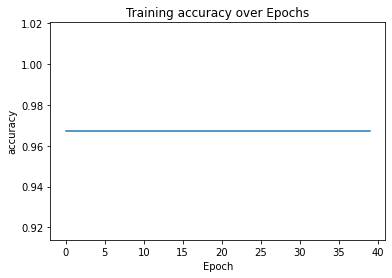

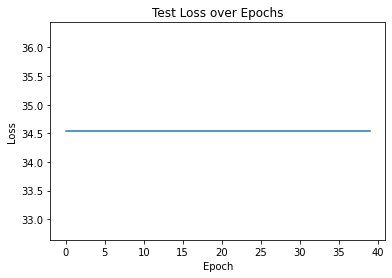

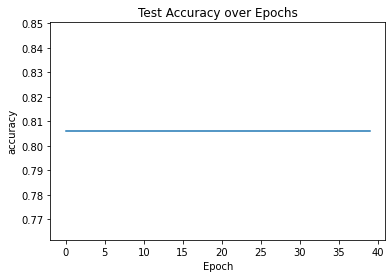

In [23]:
datas = train_x
y_trues = train_y

l = 4
t = [50,20,8,1]
n = datas.shape[1]
p = datas.shape[0]
f = ['identity', 'identity', 'identity', 'identity']

learning_rate = 0.000000001
epochs = 40

model = mlp(l,t,n,p,f,'rand_s')

model = backpropagation(model, epochs, datas, y_trues, learning_rate, test_x, test_y)

loss , accuracy = forward(model, datas, y_trues)

print("train loss and accuracy")
print(loss, accuracy)

datas = test_x
y_trues = test_y

loss , accuracy = forward(model, datas, y_trues)

print("test loss and accuracy")
print(loss, accuracy)

plt.plot(range(epochs), model["losses"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training accuracy over Epochs')
plt.show()

plt.plot(range(epochs), model["losses_test"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc_test"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Test Accuracy over Epochs')
plt.show()

test 1.2

Epoch 0, data0, Loss: 0.030298248296931268
Epoch 0, data500, Loss: 18.77216914265475
Epoch 10, data0, Loss: 0.023399235898703647
Epoch 10, data500, Loss: 14.905476254425903
Epoch 20, data0, Loss: 0.029426003126925667
Epoch 20, data500, Loss: 15.284493264574635
train loss and accuracy
0.6988813340630882 0.9671666666666666
test loss and accuracy
0.6994614016259664 0.806


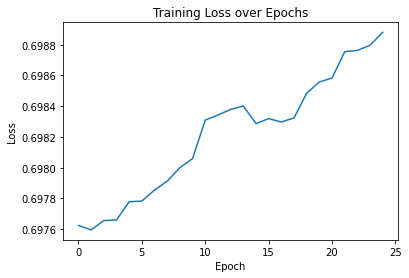

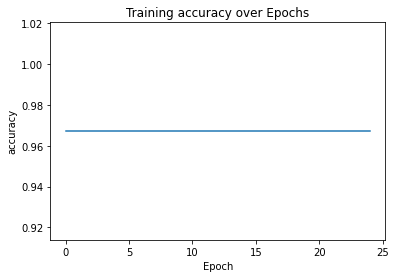

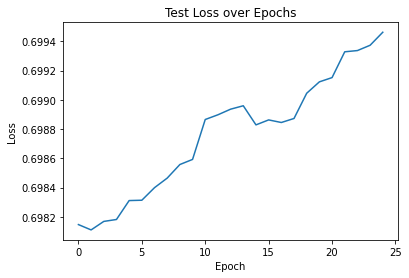

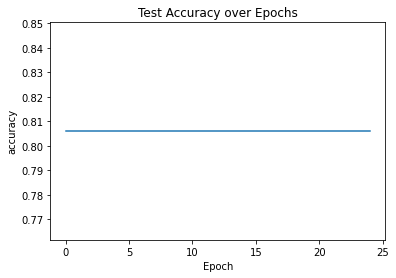

In [89]:
datas = train_x
y_trues = train_y

l = 4
t = [50,20,8,1]
n = datas.shape[1]
p = datas.shape[0]
f = ['leaky_relu', 'identity', 'identity', 'sigmoid']

learning_rate = 0.000000001
epochs = 25

model = mlp(l,t,n,p,f,'rand_s')

model = backpropagation(model, epochs, datas, y_trues, learning_rate, test_x, test_y)

loss , accuracy = forward(model, datas, y_trues)

print("train loss and accuracy")
print(loss, accuracy)

datas = test_x
y_trues = test_y

loss , accuracy = forward(model, datas, y_trues)

print("test loss and accuracy")
print(loss, accuracy)

plt.plot(range(epochs), model["losses"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training accuracy over Epochs')
plt.show()

plt.plot(range(epochs), model["losses_test"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc_test"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Test Accuracy over Epochs')
plt.show()

test 1.3

Epoch 0, data0, Loss: 0.01498788580921196
Epoch 0, data500, Loss: 23.17462299172746
Epoch 10, data0, Loss: 0.02365899760158691
Epoch 10, data500, Loss: 26.555453903644242
Epoch 20, data0, Loss: 0.02715424067655542
Epoch 20, data500, Loss: 26.473032771416364
train loss and accuracy
0.7222022557370538 0.9671666666666666
test loss and accuracy
0.7168333453816205 0.806


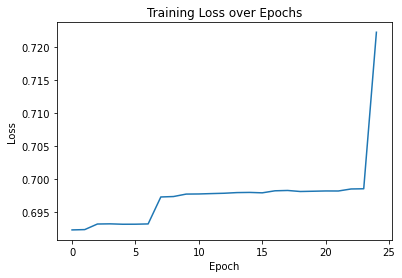

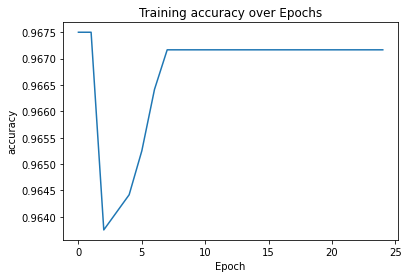

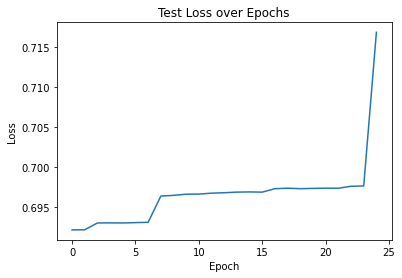

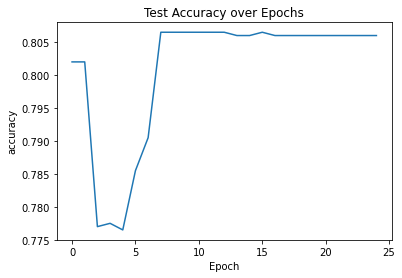

In [90]:
datas = train_x
y_trues = train_y

l = 4
t = [50,20,8,1]
n = datas.shape[1]
p = datas.shape[0]
f = ['relu', 'relu', 'identity', 'sigmoid']

learning_rate = 0.000000001
epochs = 25

model = mlp(l,t,n,p,f,'rand_s')

model = backpropagation(model, epochs, datas, y_trues, learning_rate, test_x, test_y)

loss , accuracy = forward(model, datas, y_trues)

print("train loss and accuracy")
print(loss, accuracy)

datas = test_x
y_trues = test_y

loss , accuracy = forward(model, datas, y_trues)

print("test loss and accuracy")
print(loss, accuracy)

plt.plot(range(epochs), model["losses"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training accuracy over Epochs')
plt.show()

plt.plot(range(epochs), model["losses_test"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc_test"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Test Accuracy over Epochs')
plt.show()

test 1.4

Epoch 0, data0, Loss: 0.6954064842149015
Epoch 0, data500, Loss: 0.6906163106145937
Epoch 10, data0, Loss: 0.6951680375689859
Epoch 10, data500, Loss: 0.6907673650645882
Epoch 20, data0, Loss: 0.6949186170521767
Epoch 20, data500, Loss: 0.6913008746312409
train loss and accuracy
0.6880402749185512 0.9675
test loss and accuracy
0.6880367378380158 0.802


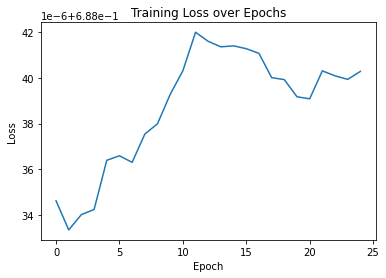

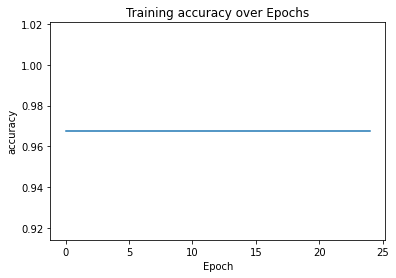

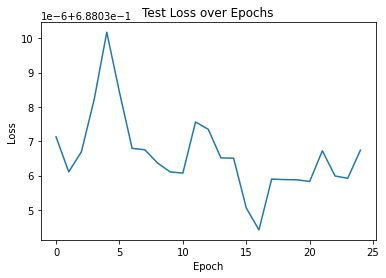

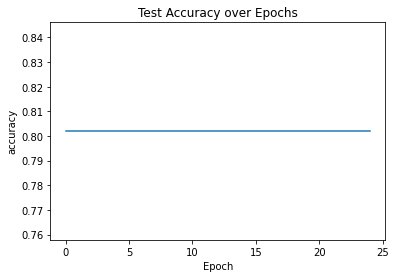

In [91]:
datas = train_x
y_trues = train_y

l = 4
t = [50,20,8,1]
n = datas.shape[1]
p = datas.shape[0]
f = ['tanh', 'tanh', 'sigmoid', 'sigmoid']

learning_rate = 0.000000001
epochs = 25

model = mlp(l,t,n,p,f,'rand_s')

model = backpropagation(model, epochs, datas, y_trues, learning_rate, test_x, test_y)

loss , accuracy = forward(model, datas, y_trues)

print("train loss and accuracy")
print(loss, accuracy)

datas = test_x
y_trues = test_y

loss , accuracy = forward(model, datas, y_trues)

print("test loss and accuracy")
print(loss, accuracy)

plt.plot(range(epochs), model["losses"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training accuracy over Epochs')
plt.show()

plt.plot(range(epochs), model["losses_test"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc_test"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Test Accuracy over Epochs')
plt.show()

test 1.5

Epoch 0, data0, Loss: 0.011521286843408486
Epoch 0, data500, Loss: 24.2339904326318
Epoch 10, data0, Loss: 0.01043286856783599
Epoch 10, data500, Loss: 19.10324522058792
Epoch 20, data0, Loss: 0.005353619153840209
Epoch 20, data500, Loss: 19.119867320485064
train loss and accuracy
34.538776394910684 0.9671666666666666
test loss and accuracy
34.538776394910684 0.806


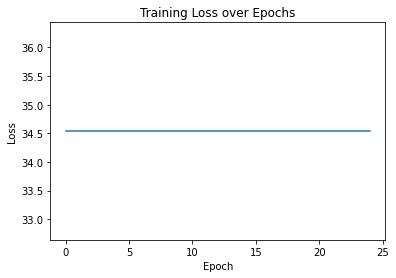

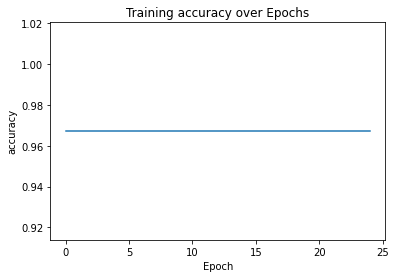

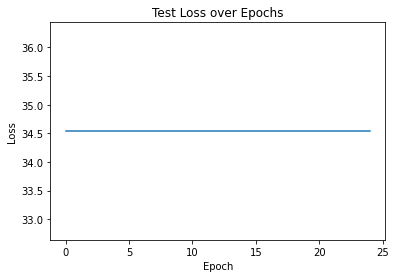

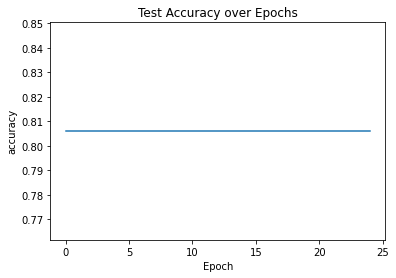

In [92]:
datas = train_x
y_trues = train_y

l = 5
t = [50,25,12,4,1]
n = datas.shape[1]
p = datas.shape[0]
f = ['identity', 'tanh', 'relu','leaky_relu', 'identity']

learning_rate = 0.000000001
epochs = 25

model = mlp(l,t,n,p,f,'rand_s')

model = backpropagation(model, epochs, datas, y_trues, learning_rate, test_x, test_y)

loss , accuracy = forward(model, datas, y_trues)

print("train loss and accuracy")
print(loss, accuracy)

datas = test_x
y_trues = test_y

loss , accuracy = forward(model, datas, y_trues)

print("test loss and accuracy")
print(loss, accuracy)

plt.plot(range(epochs), model["losses"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training accuracy over Epochs')
plt.show()

plt.plot(range(epochs), model["losses_test"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc_test"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Test Accuracy over Epochs')
plt.show()

test 2.1

Epoch 0, data0, Loss: 0.6931471805599453
Epoch 0, data500, Loss: 0.3636062045684014
Epoch 10, data0, Loss: 1.6445025442901078
Epoch 10, data500, Loss: 0.3636062045678327
Epoch 20, data0, Loss: 1.6445025442944818
Epoch 20, data500, Loss: 0.36360620456726417
train loss and accuracy
0.2145661945879601 0.9675
test loss and accuracy
0.2145661945879601 0.802


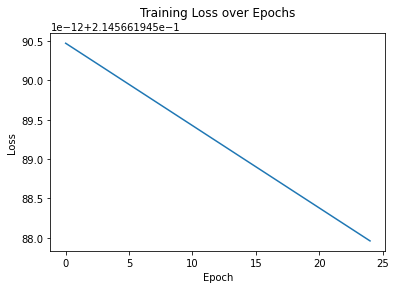

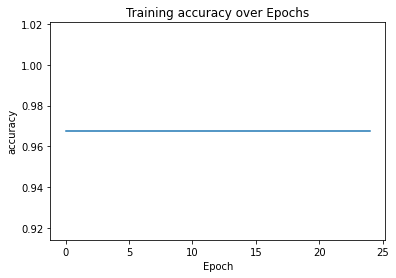

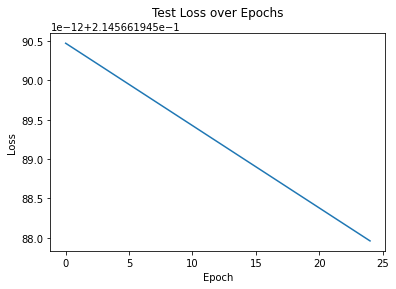

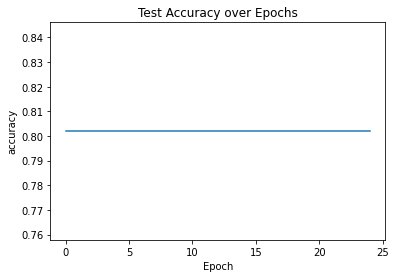

In [93]:
datas = train_x
y_trues = train_y

l = 3
t = [32,16,1]
n = datas.shape[1]
p = datas.shape[0]
f = ['tanh', 'leaky_relu', 'sigmoid']

learning_rate = 0.000000001
epochs = 25

model = mlp(l,t,n,p,f,'zero')

model = backpropagation(model, epochs, datas, y_trues, learning_rate, test_x, test_y)

loss , accuracy = forward(model, datas, y_trues)

print("train loss and accuracy")
print(loss, accuracy)

datas = test_x
y_trues = test_y

loss , accuracy = forward(model, datas, y_trues)

print("test loss and accuracy")
print(loss, accuracy)

plt.plot(range(epochs), model["losses"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training accuracy over Epochs')
plt.show()

plt.plot(range(epochs), model["losses_test"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc_test"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Test Accuracy over Epochs')
plt.show()

test 2.2

Epoch 0, data0, Loss: 0.689960885761666
Epoch 0, data500, Loss: 0.6970301175269686
Epoch 10, data0, Loss: 0.6896715391980763
Epoch 10, data500, Loss: 0.6963561115736563
Epoch 20, data0, Loss: 0.6895289022757967
Epoch 20, data500, Loss: 0.6967653493207526
train loss and accuracy
0.6975041412420958 0.9671666666666666
test loss and accuracy
0.6969052942339031 0.806


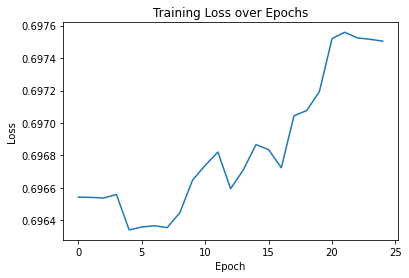

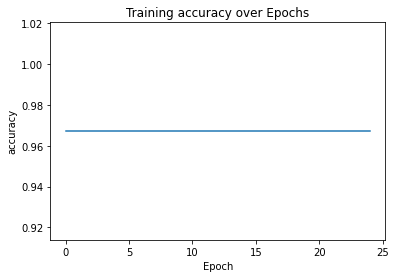

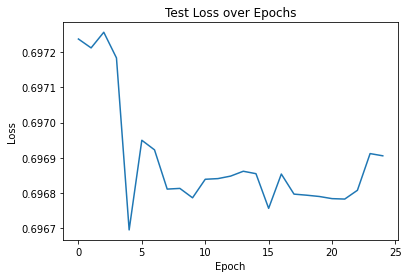

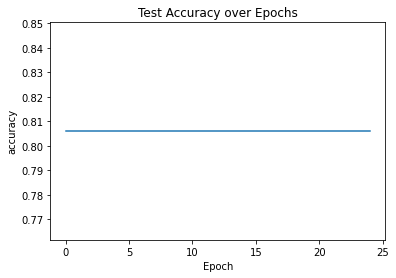

In [94]:
datas = train_x
y_trues = train_y

l = 3
t = [32,16,1]
n = datas.shape[1]
p = datas.shape[0]
f = ['tanh', 'leaky_relu', 'sigmoid']

learning_rate = 0.000000001
epochs = 25

model = mlp(l,t,n,p,f,'rand_s')

model = backpropagation(model, epochs, datas, y_trues, learning_rate, test_x, test_y)

loss , accuracy = forward(model, datas, y_trues)

print("train loss and accuracy")
print(loss, accuracy)

datas = test_x
y_trues = test_y

loss , accuracy = forward(model, datas, y_trues)

print("test loss and accuracy")
print(loss, accuracy)

plt.plot(range(epochs), model["losses"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training accuracy over Epochs')
plt.show()

plt.plot(range(epochs), model["losses_test"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc_test"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Test Accuracy over Epochs')
plt.show()

test 2.3

<ipython-input-5-b683d5dd8fa4>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 0, data0, Loss: 11.36216334623021
Epoch 0, data500, Loss: 2.384674904832907e-09
Epoch 10, data0, Loss: 11.36200370899856
Epoch 10, data500, Loss: 2.387203992889037e-09
Epoch 20, data0, Loss: 11.361974759431137
Epoch 20, data500, Loss: 2.388671929775702e-09
train loss and accuracy
14.659309018910125 0.9834166666666667
test loss and accuracy
3.4104343571486644 0.897


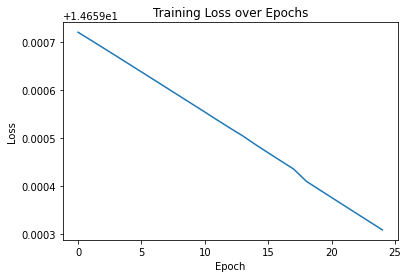

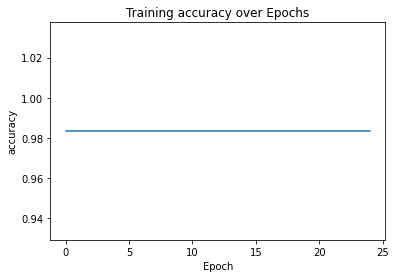

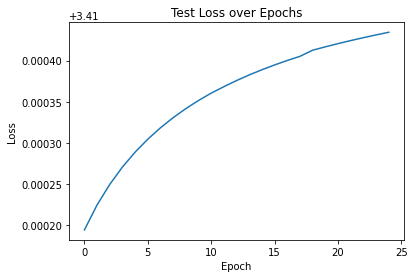

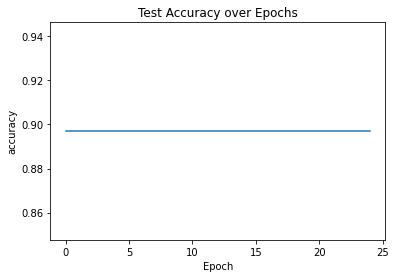

In [95]:
datas = train_x
y_trues = train_y

l = 3
t = [32,16,1]
n = datas.shape[1]
p = datas.shape[0]
f = ['tanh', 'leaky_relu', 'sigmoid']

learning_rate = 0.000000001
epochs = 25

model = mlp(l,t,n,p,f,'rand_l')

model = backpropagation(model, epochs, datas, y_trues, learning_rate, test_x, test_y)

loss , accuracy = forward(model, datas, y_trues)

print("train loss and accuracy")
print(loss, accuracy)

datas = test_x
y_trues = test_y

loss , accuracy = forward(model, datas, y_trues)

print("test loss and accuracy")
print(loss, accuracy)

plt.plot(range(epochs), model["losses"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training accuracy over Epochs')
plt.show()

plt.plot(range(epochs), model["losses_test"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc_test"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Test Accuracy over Epochs')
plt.show()

test 2.4

Epoch 0, data0, Loss: 1.236497685778298
Epoch 0, data500, Loss: 0.19209341430624313


<ipython-input-5-b683d5dd8fa4>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 10, data0, Loss: 1.4960557632785423
Epoch 10, data500, Loss: 0.184620940765876
Epoch 20, data0, Loss: 1.5557525672622137
Epoch 20, data500, Loss: 0.18451945584390225
train loss and accuracy
0.32466002397578714 0.9674166666666667
test loss and accuracy
0.28618426171393097 0.8015


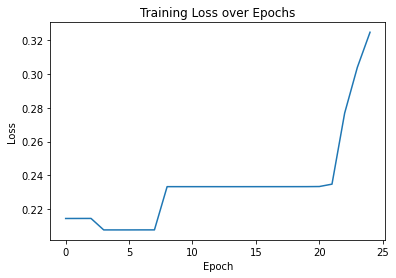

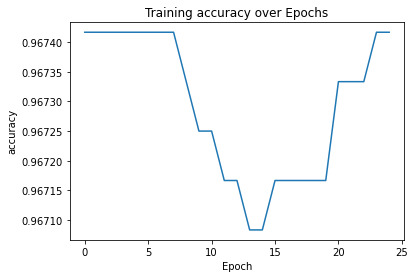

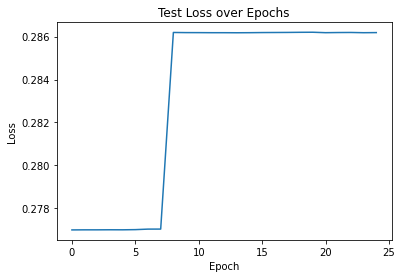

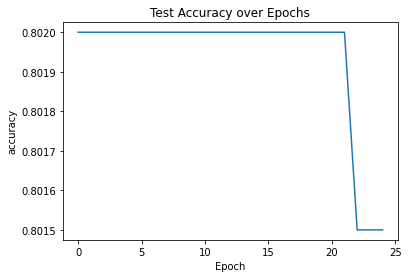

In [96]:
datas = train_x
y_trues = train_y

l = 3
t = [32,16,1]
n = datas.shape[1]
p = datas.shape[0]
f = ['tanh', 'leaky_relu', 'sigmoid']

learning_rate = 0.000000001
epochs = 25

model = mlp(l,t,n,p,f,'xavier')

model = backpropagation(model, epochs, datas, y_trues, learning_rate, test_x, test_y)

loss , accuracy = forward(model, datas, y_trues)

print("train loss and accuracy")
print(loss, accuracy)

datas = test_x
y_trues = test_y

loss , accuracy = forward(model, datas, y_trues)

print("test loss and accuracy")
print(loss, accuracy)

plt.plot(range(epochs), model["losses"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training accuracy over Epochs')
plt.show()

plt.plot(range(epochs), model["losses_test"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc_test"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Test Accuracy over Epochs')
plt.show()

test 2.5

Epoch 0, data0, Loss: 2.658744480818702
Epoch 0, data500, Loss: 0.065742395019617
Epoch 10, data0, Loss: 2.6767766794196217
Epoch 10, data500, Loss: 0.06853543928980081
Epoch 20, data0, Loss: 2.654769454912286
Epoch 20, data500, Loss: 0.06636976506487591
train loss and accuracy
0.06765118336644273 0.9675
test loss and accuracy
0.0686485542961549 0.802


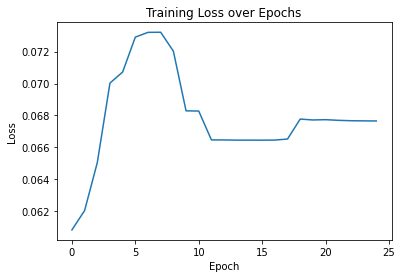

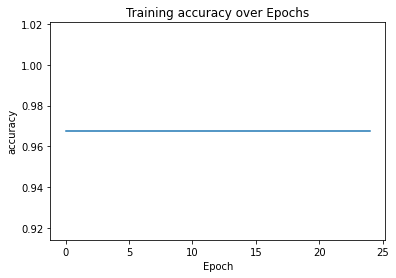

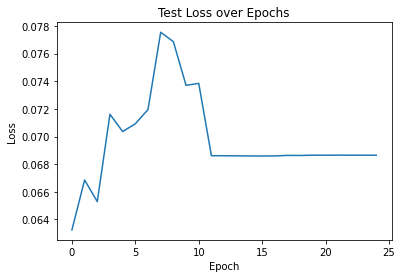

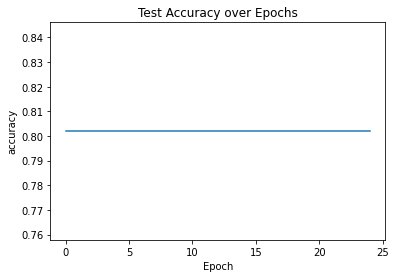

In [99]:
datas = train_x
y_trues = train_y

l = 3
t = [32,16,1]
n = datas.shape[1]
p = datas.shape[0]
f = ['tanh', 'leaky_relu', 'sigmoid']

learning_rate = 0.000000001
epochs = 25

model = mlp(l,t,n,p,f,'he')

model = backpropagation(model, epochs, datas, y_trues, learning_rate, test_x, test_y)

loss , accuracy = forward(model, datas, y_trues)

print("train loss and accuracy")
print(loss, accuracy)

datas = test_x
y_trues = test_y

loss , accuracy = forward(model, datas, y_trues)

print("test loss and accuracy")
print(loss, accuracy)

plt.plot(range(epochs), model["losses"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training accuracy over Epochs')
plt.show()

plt.plot(range(epochs), model["losses_test"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss over Epochs')
plt.show()

plt.plot(range(epochs), model["acc_test"])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Test Accuracy over Epochs')
plt.show()

SGD

In [55]:
def sigmoid(x):
    # Clip the input values to prevent overflow
    clipped_x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-clipped_x))

In [71]:
# Initialize lists to store training and test losses
train_losses = []
test_losses = []

# Initialize lists to store training and test accuracies
train_accuracies = []
test_accuracies = []

X_train = train_x
X_test = test_x
y_train = train_y
y_test = test_y

# Neural Network Parameters
input_size = 784
hidden_size = 256
output_size = 1  # Output size for binary classification
learning_rate = 0.001
epochs = 200

# Initialize weights and biases
W1 = random_init_s(input_size, hidden_size)
b1 = random_init_s(1, hidden_size)
W2 = random_init_s(hidden_size, output_size)
b2 = random_init_s(1, output_size)

batch_size = 32
epsilon = 1e-8

# Batch normalization parameters
gamma1 = np.ones((1, hidden_size))
beta1 = np.zeros((1, hidden_size))
gamma2 = np.ones((1, output_size))
beta2 = np.zeros((1, output_size))

# Training loop
for epoch in range(epochs):
    total_loss = 0.0  # Initialize total loss for the epoch
    for i in range(0, len(X_train), batch_size):
        # Forward propagation
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        z1 = np.dot(X_batch, W1) + b1
        z1_norm = (z1 - np.mean(z1, axis=0)) / np.sqrt(np.var(z1, axis=0) + epsilon)
        a1 = leaky_relu(gamma1 * z1_norm + beta1)

#         z2 = np.dot(a1, W2) + b2
#         z2_norm = (z2 - np.mean(z2, axis=0)) / np.sqrt(np.var(z2, axis=0) + epsilon)
#         a2 = sigmoid(gamma2 * z2_norm + beta2)

        z2 = np.dot(a1, W2) + b2
        z2_norm = (z2 - np.mean(z2, axis=0)) / np.sqrt(np.var(z2, axis=0) + epsilon)
        z2_clipped = np.clip(z2_norm, -500, 500)  # Clip values to prevent overflow
        a2 = sigmoid(gamma2 * z2_clipped + beta2)
        
        # Backpropagation
        delta2 = (a2 - y_batch.reshape(-1, 1)) * sigmoid_derivative(a2)
        dW2 = np.dot(a1.T, delta2)
        db2 = np.sum(delta2, axis=0, keepdims=True)
        delta1 = np.dot(delta2, W2.T) * leaky_relu_derivative(z1)
        dW1 = np.dot(X_batch.T, delta1)
        db1 = np.sum(delta1, axis=0)

        # Calculate loss for the current batch
        batch_loss = -np.sum(y_batch * np.log(a2) + (1 - y_batch) * np.log(1 - a2)) / len(X_batch)
        total_loss += batch_loss

        # Update weights and biases
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        
        # Update batch normalization parameters
        gamma1 -= learning_rate * np.sum(delta1 * z1_norm, axis=0)
        beta1 -= learning_rate * np.sum(delta1, axis=0)
        gamma2 -= learning_rate * np.sum(delta2 * z2_norm, axis=0)
        beta2 -= learning_rate * np.sum(delta2, axis=0)
        
        # Calculate loss for the current batch and add it to the total loss for the epoch
        batch_loss = -np.sum(y_batch * np.log(a2) + (1 - y_batch) * np.log(1 - a2)) / len(X_batch)
        total_loss += batch_loss
    
    # Average loss over all batches for the epoch
    avg_loss = total_loss / (len(X_train) / batch_size)
    train_losses.append(avg_loss)  # Store training loss for the epoch
    
    z1 = np.dot(X_train, W1) + b1
    a1 = leaky_relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2_train = sigmoid(z2)
    
    # Calculate training accuracy for the epoch
    train_predictions = (a2_train > 0.5).astype(int)
    train_accuracy = np.mean(train_predictions == y_train)
    train_accuracies.append(train_accuracy)  # Store training accuracy for the epoch

    # Testing
    z1 = np.dot(X_test, W1) + b1
    a1 = leaky_relu(z1)
#     z2 = np.dot(a1, W2) + b2
#     a2 = sigmoid(z2)

    # Testing
    z2 = np.dot(a1, W2) + b2
    z2_norm = (z2 - np.mean(z2, axis=0)) / np.sqrt(np.var(z2, axis=0) + epsilon)
    z2_clipped = np.clip(z2_norm, -500, 500)  # Clip values to prevent overflow
    a2 = sigmoid(gamma2 * z2_clipped + beta2)


    # Calculate test loss
    test_loss = -np.sum(y_test * np.log(a2) + (1 - y_test) * np.log(1 - a2)) / (len(X_test) + epsilon)
    test_losses.append(test_loss)  # Store test loss for the epoch
    
    # Calculate test accuracy
    test_predictions = (a2 > 0.5).astype(int)
    test_accuracy = np.mean(test_predictions == y_test)
    test_accuracies.append(test_accuracy)  # Store test accuracy for the epoch

    # Print average loss for the epoch
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')

# Plotting
plt.figure(figsize=(12, 6))

# Plot training and test losses
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

# Plot training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/200, Average Loss: 55.18594867149831, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 2/200, Average Loss: 61.53674903523477, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 3/200, Average Loss: 67.08208928418435, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 4/200, Average Loss: 71.95561219000805, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 5/200, Average Loss: 76.27451220769376, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 6/200, Average Loss: 80.12242711367298, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 7/200, Average Loss: 83.56236264152857, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 8/200, Average Loss: 86.65160813096183, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 9/200, Average Loss: 89.44789936551979, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 10/200, Average Loss: 92.00493788740138, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 11/200, Average Loss: 94.37051836526584, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 12/200, Average Loss: 96.58400740771503, Train

KeyboardInterrupt: 

Epoch 1/200, Average Loss: 205.8879429521248, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 2/200, Average Loss: 205.88794523498447, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 3/200, Average Loss: 205.88794751970275, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 4/200, Average Loss: 205.88794980610916, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 5/200, Average Loss: 205.8879520944842, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 6/200, Average Loss: 205.88795438489058, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 7/200, Average Loss: 205.8879566772574, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 8/200, Average Loss: 205.88795897148313, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 9/200, Average Loss: 205.88796126709832, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 10/200, Average Loss: 205.88796356107096, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 11/200, Average Loss: 205.88796586246664, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 12/200, Average Loss: 205.887968169500

Epoch 95/200, Average Loss: 205.8881663737851, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 96/200, Average Loss: 205.88816883341457, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 97/200, Average Loss: 205.88817129500953, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 98/200, Average Loss: 205.88817375850167, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 99/200, Average Loss: 205.88817622433518, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 100/200, Average Loss: 205.88817869152567, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 101/200, Average Loss: 205.8881811608366, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 102/200, Average Loss: 205.88818363204388, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 103/200, Average Loss: 205.88818610521798, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 104/200, Average Loss: 205.88818858035833, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 105/200, Average Loss: 205.88819105746543, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 106/200, Average Loss:

Epoch 188/200, Average Loss: 205.88840318189398, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 189/200, Average Loss: 205.8884058046431, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 190/200, Average Loss: 205.8884084296151, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 191/200, Average Loss: 205.88841105567099, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 192/200, Average Loss: 205.88841368001474, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 193/200, Average Loss: 205.8884163054033, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 194/200, Average Loss: 205.88841893282944, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 195/200, Average Loss: 205.88842156221574, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 196/200, Average Loss: 205.88842419356234, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 197/200, Average Loss: 205.8884268263311, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 198/200, Average Loss: 205.88842946159644, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 199/200, Average Lo

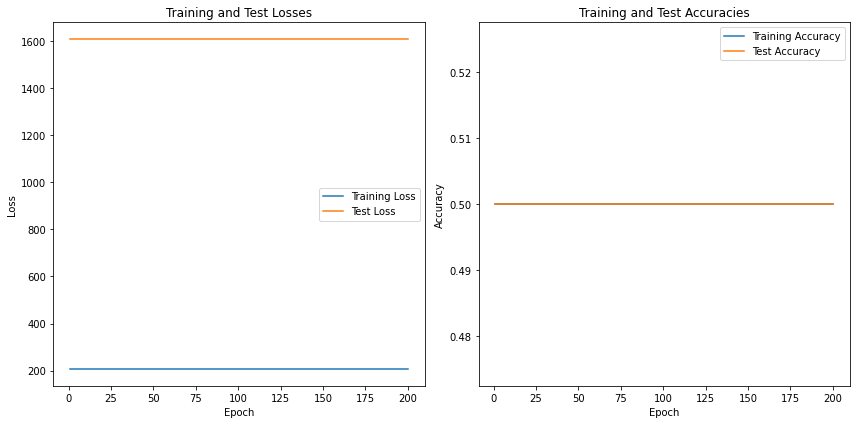

In [63]:
# Initialize lists to store training and test losses
train_losses = []
test_losses = []

# Initialize lists to store training and test accuracies
train_accuracies = []
test_accuracies = []

X_train = train_x
X_test = test_x
y_train = train_y
y_test = test_y

# Neural Network Parameters
input_size = 784
hidden_size = 32
output_size = 1  # Output size for binary classification
learning_rate = 0.00000000001
epochs = 200

# Initialize weights and biases
W1 = random_init_s(input_size, hidden_size)
b1 = random_init_s(1, hidden_size)
W2 = random_init_s(hidden_size, output_size)
b2 = random_init_s(1, output_size)

batch_size = 128
epsilon = 1e-8

# Batch normalization parameters
gamma1 = np.ones((1, hidden_size))
beta1 = np.zeros((1, hidden_size))
gamma2 = np.ones((1, output_size))
beta2 = np.zeros((1, output_size))

# Training loop
for epoch in range(epochs):
    total_loss = 0.0  # Initialize total loss for the epoch
    for i in range(0, len(X_train), batch_size):
        # Forward propagation
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        z1 = np.dot(X_batch, W1) + b1
        z1_norm = (z1 - np.mean(z1, axis=0)) / np.sqrt(np.var(z1, axis=0) + epsilon)
        a1 = relu(gamma1 * z1_norm + beta1)

#         z2 = np.dot(a1, W2) + b2
#         z2_norm = (z2 - np.mean(z2, axis=0)) / np.sqrt(np.var(z2, axis=0) + epsilon)
#         a2 = sigmoid(gamma2 * z2_norm + beta2)

        z2 = np.dot(a1, W2) + b2
        z2_norm = (z2 - np.mean(z2, axis=0)) / np.sqrt(np.var(z2, axis=0) + epsilon)
        z2_clipped = np.clip(z2_norm, -500, 500)  # Clip values to prevent overflow
        a2 = sigmoid(gamma2 * z2_clipped + beta2)
        
        # Backpropagation
        delta2 = (a2 - y_batch.reshape(-1, 1)) * sigmoid_derivative(a2)
        dW2 = np.dot(a1.T, delta2)
        db2 = np.sum(delta2, axis=0, keepdims=True)
        delta1 = np.dot(delta2, W2.T) * (z1 > 0)
        dW1 = np.dot(X_batch.T, delta1)
        db1 = np.sum(delta1, axis=0)

        # Calculate loss for the current batch
        batch_loss = -np.sum(y_batch * np.log(a2) + (1 - y_batch) * np.log(1 - a2)) / len(X_batch)
        total_loss += batch_loss

        # Update weights and biases
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        
        # Update batch normalization parameters
        gamma1 -= learning_rate * np.sum(delta1 * z1_norm, axis=0)
        beta1 -= learning_rate * np.sum(delta1, axis=0)
        gamma2 -= learning_rate * np.sum(delta2 * z2_norm, axis=0)
        beta2 -= learning_rate * np.sum(delta2, axis=0)
        
        # Calculate loss for the current batch and add it to the total loss for the epoch
        batch_loss = -np.sum(y_batch * np.log(a2) + (1 - y_batch) * np.log(1 - a2)) / len(X_batch)
        total_loss += batch_loss
    
    # Average loss over all batches for the epoch
    avg_loss = total_loss / (len(X_train) / batch_size)
    train_losses.append(avg_loss)  # Store training loss for the epoch
    
    z1 = np.dot(X_train, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2_train = sigmoid(z2)
    
    # Calculate training accuracy for the epoch
    train_predictions = (a2_train > 0.5).astype(int)
    train_accuracy = np.mean(train_predictions == y_train)
    train_accuracies.append(train_accuracy)  # Store training accuracy for the epoch

    # Testing
    z1 = np.dot(X_test, W1) + b1
    a1 = relu(z1)
#     z2 = np.dot(a1, W2) + b2
#     a2 = sigmoid(z2)

    # Testing
    z2 = np.dot(a1, W2) + b2
    z2_norm = (z2 - np.mean(z2, axis=0)) / np.sqrt(np.var(z2, axis=0) + epsilon)
    z2_clipped = np.clip(z2_norm, -500, 500)  # Clip values to prevent overflow
    a2 = sigmoid(gamma2 * z2_clipped + beta2)


    # Calculate test loss
    test_loss = -np.sum(y_test * np.log(a2) + (1 - y_test) * np.log(1 - a2)) / (len(X_test) + epsilon)
    test_losses.append(test_loss)  # Store test loss for the epoch
    
    # Calculate test accuracy
    test_predictions = (a2 > 0.5).astype(int)
    test_accuracy = np.mean(test_predictions == y_test)
    test_accuracies.append(test_accuracy)  # Store test accuracy for the epoch

    # Print average loss for the epoch
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')

# Plotting
plt.figure(figsize=(12, 6))

# Plot training and test losses
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

# Plot training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/200, Average Loss: 53.97919902429288, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 2/200, Average Loss: 57.14696630931855, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 3/200, Average Loss: 60.081047129225645, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 4/200, Average Loss: 63.77700287460292, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 5/200, Average Loss: 68.34359104455469, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 6/200, Average Loss: 71.70864186838759, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 7/200, Average Loss: 75.95264465082361, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 8/200, Average Loss: 79.76492574939391, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 9/200, Average Loss: 82.18745242546329, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 10/200, Average Loss: 80.71979726462179, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 11/200, Average Loss: 79.08054826460025, Train Accuracy: 0.5, Test Accuracy: 0.5


c:\users\lenovo\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Epoch 12/200, Average Loss: 77.14957054320205, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 13/200, Average Loss: 77.65701374168435, Train Accuracy: 0.5, Test Accuracy: 0.5


c:\users\lenovo\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Epoch 14/200, Average Loss: 73.1540617447032, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 15/200, Average Loss: 64.19219944327655, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 16/200, Average Loss: 57.96335951854789, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 17/200, Average Loss: 44.40772730968615, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 18/200, Average Loss: 44.37105423321854, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 19/200, Average Loss: 44.363583177711135, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 20/200, Average Loss: 44.36246732319625, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 21/200, Average Loss: 44.36254100438552, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 22/200, Average Loss: 44.362729347937204, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 23/200, Average Loss: 44.36285935669352, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 24/200, Average Loss: 44.3629325705525, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 25/200, Average Loss: 44.362970920227

c:\users\lenovo\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\users\lenovo\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
<ipython-input-72-65d8d22ca4a0>:141: RuntimeWarning: invalid value encountered in divide
  z4_norm = (z4 - np.mean(z4, axis=0)) / np.sqrt(np.var(z4, axis=0) + epsilon)


Epoch 53/200, Average Loss: 44.363009727286, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 54/200, Average Loss: 44.36300972728601, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 55/200, Average Loss: 44.36300972728603, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 56/200, Average Loss: 44.36300972728599, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 57/200, Average Loss: 44.36300972728592, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 58/200, Average Loss: 44.36300972728594, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 59/200, Average Loss: 44.363009727285935, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 60/200, Average Loss: 44.36300972728592, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 61/200, Average Loss: 44.363009727285935, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 62/200, Average Loss: 44.36300972728592, Train Accuracy: 0.5, Test Accuracy: 0.5


<ipython-input-72-65d8d22ca4a0>:141: RuntimeWarning: invalid value encountered in subtract
  z4_norm = (z4 - np.mean(z4, axis=0)) / np.sqrt(np.var(z4, axis=0) + epsilon)
c:\users\lenovo\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Epoch 63/200, Average Loss: 44.363009727285935, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 64/200, Average Loss: 44.36300972728592, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 65/200, Average Loss: 44.363009727285935, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 66/200, Average Loss: 44.363009727285935, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 67/200, Average Loss: 44.363009727285935, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 68/200, Average Loss: 44.363009727285935, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 69/200, Average Loss: 44.363009727285935, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 70/200, Average Loss: 44.363009727285935, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 71/200, Average Loss: 44.363009727285935, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 72/200, Average Loss: 44.363009727285935, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 73/200, Average Loss: 44.363009727285935, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 74/200, Average Loss: 44.36

Epoch 156/200, Average Loss: 44.363009727285935, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 157/200, Average Loss: 44.363009727285935, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 158/200, Average Loss: 44.363009727285935, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 159/200, Average Loss: 44.363009727285935, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 160/200, Average Loss: 44.363009727285935, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 161/200, Average Loss: 44.363009727285935, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 162/200, Average Loss: 44.363009727285935, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 163/200, Average Loss: 44.363009727285935, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 164/200, Average Loss: 44.363009727285935, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 165/200, Average Loss: 44.363009727285935, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 166/200, Average Loss: 44.363009727285935, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 167/200, Averag

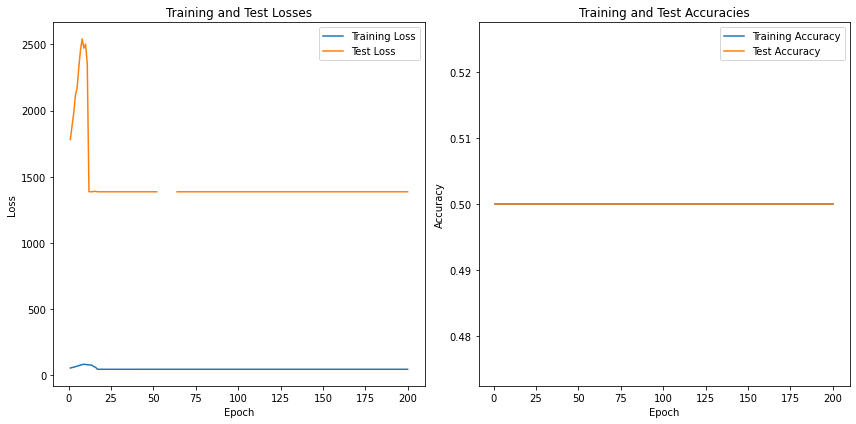

In [72]:
# Initialize lists to store training and test losses
train_losses = []
test_losses = []

# Initialize lists to store training and test accuracies
train_accuracies = []
test_accuracies = []

X_train = train_x
X_test = test_x
y_train = train_y
y_test = test_y

# Neural Network Parameters
input_size = 784
hidden_size1 = 256
hidden_size2 = 128
hidden_size3 = 64
output_size = 1  # Output size for binary classification
learning_rate = 0.001
epochs = 200

# Initialize weights and biases
W1 = random_init_s(input_size, hidden_size1)
b1 = random_init_s(1, hidden_size1)
W2 = random_init_s(hidden_size1, hidden_size2)
b2 = random_init_s(1, hidden_size2)
W3 = random_init_s(hidden_size2, hidden_size3)
b3 = random_init_s(1, hidden_size3)
W4 = random_init_s(hidden_size3, output_size)
b4 = random_init_s(1, output_size)

batch_size = 32
epsilon = 1e-8

# Batch normalization parameters
gamma1 = np.ones((1, hidden_size1))
beta1 = np.zeros((1, hidden_size1))
gamma2 = np.ones((1, hidden_size2))
beta2 = np.zeros((1, hidden_size2))
gamma3 = np.ones((1, hidden_size3))
beta3 = np.zeros((1, hidden_size3))
gamma4 = np.ones((1, output_size))
beta4 = np.zeros((1, output_size))

# Training loop
for epoch in range(epochs):
    total_loss = 0.0  # Initialize total loss for the epoch
    for i in range(0, len(X_train), batch_size):
        # Forward propagation
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        z1 = np.dot(X_batch, W1) + b1
        z1_norm = (z1 - np.mean(z1, axis=0)) / np.sqrt(np.var(z1, axis=0) + epsilon)
        a1 = leaky_relu(gamma1 * z1_norm + beta1)

        z2 = np.dot(a1, W2) + b2
        z2_norm = (z2 - np.mean(z2, axis=0)) / np.sqrt(np.var(z2, axis=0) + epsilon)
        a2 = leaky_relu(gamma2 * z2_norm + beta2)
        
        z3 = np.dot(a2, W3) + b3
        z3_norm = (z3 - np.mean(z3, axis=0)) / np.sqrt(np.var(z3, axis=0) + epsilon)
        a3 = leaky_relu(gamma3 * z3_norm + beta3)

        z4 = np.dot(a3, W4) + b4
        z4_norm = (z4 - np.mean(z4, axis=0)) / np.sqrt(np.var(z4, axis=0) + epsilon)
        z4_clipped = np.clip(z4_norm, -500, 500)  # Clip values to prevent overflow
        a4 = sigmoid(gamma4 * z4_clipped + beta4)
        
        # Backpropagation
        delta4 = (a4 - y_batch.reshape(-1, 1)) * sigmoid_derivative(a4)
        dW4 = np.dot(a3.T, delta4)
        db4 = np.sum(delta4, axis=0, keepdims=True)
        delta3 = np.dot(delta4, W4.T) * leaky_relu_derivative(z3)
        dW3 = np.dot(a2.T, delta3)
        db3 = np.sum(delta3, axis=0)

        delta2 = np.dot(delta3, W3.T) * leaky_relu_derivative(z2)
        dW2 = np.dot(a1.T, delta2)
        db2 = np.sum(delta2, axis=0)

        delta1 = np.dot(delta2, W2.T) * leaky_relu_derivative(z1)
        dW1 = np.dot(X_batch.T, delta1)
        db1 = np.sum(delta1, axis=0)

        # Calculate loss for the current batch
        batch_loss = -np.sum(y_batch * np.log(a4) + (1 - y_batch) * np.log(1 - a4)) / len(X_batch)
        total_loss += batch_loss

        # Update weights and biases
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        W3 -= learning_rate * dW3
        b3 -= learning_rate * db3
        W4 -= learning_rate * dW4
        b4 -= learning_rate * db4
        
        # Update batch normalization parameters
        gamma1 -= learning_rate * np.sum(delta1 * z1_norm, axis=0)
        beta1 -= learning_rate * np.sum(delta1, axis=0)
        gamma2 -= learning_rate * np.sum(delta2 * z2_norm, axis=0)
        beta2 -= learning_rate * np.sum(delta2, axis=0)
        gamma3 -= learning_rate * np.sum(delta3 * z3_norm, axis=0)
        beta3 -= learning_rate * np.sum(delta3, axis=0)
        gamma4 -= learning_rate * np.sum(delta4 * z4_norm, axis=0)
        beta4 -= learning_rate * np.sum(delta4, axis=0)
        
        # Calculate loss for the current batch and add it to the total loss for the epoch
        batch_loss = -np.sum(y_batch * np.log(a4) + (1 - y_batch) * np.log(1 - a4)) / len(X_batch)
        total_loss += batch_loss
    
    # Average loss over all batches for the epoch
    avg_loss = total_loss / (len(X_train) / batch_size)
    train_losses.append(avg_loss)  # Store training loss for the epoch
    
    z1 = np.dot(X_train, W1) + b1
    a1 = leaky_relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = leaky_relu(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = leaky_relu(z3)
    z4 = np.dot(a3, W4) + b4
    a4_train = sigmoid(z4)
    
    # Calculate training accuracy for the epoch
    train_predictions = (a4_train > 0.5).astype(int)
    train_accuracy = np.mean(train_predictions == y_train)
    train_accuracies.append(train_accuracy)  # Store training accuracy for the epoch

    # Testing
    z1 = np.dot(X_test, W1) + b1
    a1 = leaky_relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = leaky_relu(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = leaky_relu(z3)
    z4 = np.dot(a3, W4) + b4
    z4_norm = (z4 - np.mean(z4, axis=0)) / np.sqrt(np.var(z4, axis=0) + epsilon)
    z4_clipped = np.clip(z4_norm, -500, 500)  # Clip values to prevent overflow
    a4 = sigmoid(gamma4 * z4_clipped + beta4)


    # Calculate test loss
    test_loss = -np.sum(y_test * np.log(a4) + (1 - y_test) * np.log(1 - a4)) / (len(X_test) + epsilon)
    test_losses.append(test_loss)  # Store test loss for the epoch
    
    # Calculate test accuracy
    test_predictions = (a4 > 0.5).astype(int)
    test_accuracy = np.mean(test_predictions == y_test)
    test_accuracies.append(test_accuracy)  # Store test accuracy for the epoch

    # Print average loss for the epoch
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')

# Plotting
plt.figure(figsize=(12, 6))

# Plot training and test losses
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

# Plot training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/200, Average Loss: 133.89464007866968, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 2/200, Average Loss: 146.36053143289948, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 3/200, Average Loss: 139.04207542398873, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 4/200, Average Loss: 137.88751310374417, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 5/200, Average Loss: 167.2777656180096, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 6/200, Average Loss: 189.30850646456258, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 7/200, Average Loss: 125.07435521237224, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 8/200, Average Loss: 121.60040238073472, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 9/200, Average Loss: 100.18360696774737, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 10/200, Average Loss: 88.73309223324722, Train Accuracy: 0.5, Test Accuracy: 0.5


<ipython-input-73-2900ab830bc8>:141: RuntimeWarning: invalid value encountered in divide
  z4_norm = (z4 - np.mean(z4, axis=0)) / np.sqrt(np.var(z4, axis=0) + epsilon)


Epoch 11/200, Average Loss: 88.73376048237735, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 12/200, Average Loss: 88.73376099653576, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 13/200, Average Loss: 88.73376099692408, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 14/200, Average Loss: 88.73376099692469, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 15/200, Average Loss: 88.73376099692872, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 16/200, Average Loss: 88.73376099692764, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 17/200, Average Loss: 88.7337609969221, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 18/200, Average Loss: 88.73376099692663, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 19/200, Average Loss: 88.73376099692312, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 20/200, Average Loss: 88.73376099692652, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 21/200, Average Loss: 88.73376099692426, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 22/200, Average Loss: 88.7337609969270

Epoch 106/200, Average Loss: 88.73376099692727, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 107/200, Average Loss: 88.73376099692791, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 108/200, Average Loss: 88.73376099692356, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 109/200, Average Loss: 88.73376099692906, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 110/200, Average Loss: 88.73376099692508, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 111/200, Average Loss: 88.73376099692351, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 112/200, Average Loss: 88.73376099692463, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 113/200, Average Loss: 88.73376099692736, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 114/200, Average Loss: 88.73376099692702, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 115/200, Average Loss: 88.73376099692689, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 116/200, Average Loss: 88.73376099692646, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 117/200, Average Loss: 88.

Epoch 200/200, Average Loss: 88.73376099692742, Train Accuracy: 0.5, Test Accuracy: 0.5


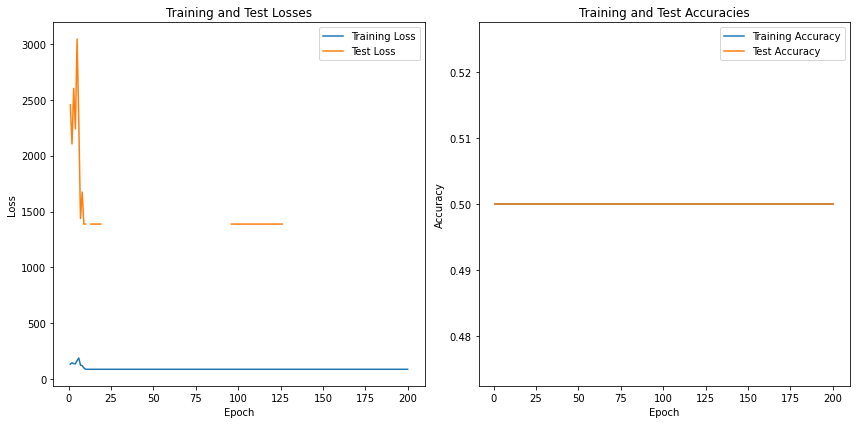

In [73]:
# Initialize lists to store training and test losses
train_losses = []
test_losses = []

# Initialize lists to store training and test accuracies
train_accuracies = []
test_accuracies = []

X_train = train_x
X_test = test_x
y_train = train_y
y_test = test_y

# Neural Network Parameters
input_size = 784
hidden_size1 = 64
hidden_size2 = 32
hidden_size3 = 16
output_size = 1  
learning_rate = 0.01
epochs = 200

# Initialize weights and biases
W1 = random_init_s(input_size, hidden_size1)
b1 = random_init_s(1, hidden_size1)
W2 = random_init_s(hidden_size1, hidden_size2)
b2 = random_init_s(1, hidden_size2)
W3 = random_init_s(hidden_size2, hidden_size3)
b3 = random_init_s(1, hidden_size3)
W4 = random_init_s(hidden_size3, output_size)
b4 = random_init_s(1, output_size)

batch_size = 64
epsilon = 1e-8

# Batch normalization parameters
gamma1 = np.ones((1, hidden_size1))
beta1 = np.zeros((1, hidden_size1))
gamma2 = np.ones((1, hidden_size2))
beta2 = np.zeros((1, hidden_size2))
gamma3 = np.ones((1, hidden_size3))
beta3 = np.zeros((1, hidden_size3))
gamma4 = np.ones((1, output_size))
beta4 = np.zeros((1, output_size))

# Training loop
for epoch in range(epochs):
    total_loss = 0.0  # Initialize total loss for the epoch
    for i in range(0, len(X_train), batch_size):
        # Forward propagation
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        z1 = np.dot(X_batch, W1) + b1
        z1_norm = (z1 - np.mean(z1, axis=0)) / np.sqrt(np.var(z1, axis=0) + epsilon)
        a1 = leaky_relu(gamma1 * z1_norm + beta1)

        z2 = np.dot(a1, W2) + b2
        z2_norm = (z2 - np.mean(z2, axis=0)) / np.sqrt(np.var(z2, axis=0) + epsilon)
        a2 = leaky_relu(gamma2 * z2_norm + beta2)
        
        z3 = np.dot(a2, W3) + b3
        z3_norm = (z3 - np.mean(z3, axis=0)) / np.sqrt(np.var(z3, axis=0) + epsilon)
        a3 = leaky_relu(gamma3 * z3_norm + beta3)

        z4 = np.dot(a3, W4) + b4
        z4_norm = (z4 - np.mean(z4, axis=0)) / np.sqrt(np.var(z4, axis=0) + epsilon)
        z4_clipped = np.clip(z4_norm, -500, 500)  # Clip values to prevent overflow
        a4 = sigmoid(gamma4 * z4_clipped + beta4)
        
        # Backpropagation
        delta4 = (a4 - y_batch.reshape(-1, 1)) * sigmoid_derivative(a4)
        dW4 = np.dot(a3.T, delta4)
        db4 = np.sum(delta4, axis=0, keepdims=True)
        delta3 = np.dot(delta4, W4.T) * leaky_relu_derivative(z3)
        dW3 = np.dot(a2.T, delta3)
        db3 = np.sum(delta3, axis=0)

        delta2 = np.dot(delta3, W3.T) * leaky_relu_derivative(z2)
        dW2 = np.dot(a1.T, delta2)
        db2 = np.sum(delta2, axis=0)

        delta1 = np.dot(delta2, W2.T) * leaky_relu_derivative(z1)
        dW1 = np.dot(X_batch.T, delta1)
        db1 = np.sum(delta1, axis=0)

        # Calculate loss for the current batch
        batch_loss = -np.sum(y_batch * np.log(a4) + (1 - y_batch) * np.log(1 - a4)) / len(X_batch)
        total_loss += batch_loss

        # Update weights and biases
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        W3 -= learning_rate * dW3
        b3 -= learning_rate * db3
        W4 -= learning_rate * dW4
        b4 -= learning_rate * db4
        
        # Update batch normalization parameters
        gamma1 -= learning_rate * np.sum(delta1 * z1_norm, axis=0)
        beta1 -= learning_rate * np.sum(delta1, axis=0)
        gamma2 -= learning_rate * np.sum(delta2 * z2_norm, axis=0)
        beta2 -= learning_rate * np.sum(delta2, axis=0)
        gamma3 -= learning_rate * np.sum(delta3 * z3_norm, axis=0)
        beta3 -= learning_rate * np.sum(delta3, axis=0)
        gamma4 -= learning_rate * np.sum(delta4 * z4_norm, axis=0)
        beta4 -= learning_rate * np.sum(delta4, axis=0)
        
        # Calculate loss for the current batch and add it to the total loss for the epoch
        batch_loss = -np.sum(y_batch * np.log(a4) + (1 - y_batch) * np.log(1 - a4)) / len(X_batch)
        total_loss += batch_loss
    
    # Average loss over all batches for the epoch
    avg_loss = total_loss / (len(X_train) / batch_size)
    train_losses.append(avg_loss)  # Store training loss for the epoch
    
    z1 = np.dot(X_train, W1) + b1
    a1 = leaky_relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = leaky_relu(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = leaky_relu(z3)
    z4 = np.dot(a3, W4) + b4
    a4_train = sigmoid(z4)
    
    # Calculate training accuracy for the epoch
    train_predictions = (a4_train > 0.5).astype(int)
    train_accuracy = np.mean(train_predictions == y_train)
    train_accuracies.append(train_accuracy)  # Store training accuracy for the epoch

    # Testing
    z1 = np.dot(X_test, W1) + b1
    a1 = leaky_relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = leaky_relu(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = leaky_relu(z3)
    z4 = np.dot(a3, W4) + b4
    z4_norm = (z4 - np.mean(z4, axis=0)) / np.sqrt(np.var(z4, axis=0) + epsilon)
    z4_clipped = np.clip(z4_norm, -500, 500)  # Clip values to prevent overflow
    a4 = sigmoid(gamma4 * z4_clipped + beta4)


    # Calculate test loss
    test_loss = -np.sum(y_test * np.log(a4) + (1 - y_test) * np.log(1 - a4)) / (len(X_test) + epsilon)
    test_losses.append(test_loss)  # Store test loss for the epoch
    
    # Calculate test accuracy
    test_predictions = (a4 > 0.5).astype(int)
    test_accuracy = np.mean(test_predictions == y_test)
    test_accuracies.append(test_accuracy)  # Store test accuracy for the epoch

    # Print average loss for the epoch
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')

# Plotting
plt.figure(figsize=(12, 6))

# Plot training and test losses
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

# Plot training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/200, Average Loss: 146.34783651205544, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 2/200, Average Loss: 174.79797146305674, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 3/200, Average Loss: 185.9901968300979, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 4/200, Average Loss: 180.12915535268226, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 5/200, Average Loss: 130.13792368908528, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 6/200, Average Loss: 133.54689916753316, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 7/200, Average Loss: 141.85302870914208, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 8/200, Average Loss: 147.646250022706, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 9/200, Average Loss: 130.55931944882008, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 10/200, Average Loss: 127.72246752219039, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 11/200, Average Loss: 126.70851196733524, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 12/200, Average Loss: 124.301547725751

<ipython-input-74-877311f4dfb9>:59: RuntimeWarning: invalid value encountered in subtract
  z2_norm = (z2 - np.mean(z2, axis=0)) / np.sqrt(np.var(z2, axis=0) + epsilon)
<ipython-input-74-877311f4dfb9>:59: RuntimeWarning: invalid value encountered in divide
  z2_norm = (z2 - np.mean(z2, axis=0)) / np.sqrt(np.var(z2, axis=0) + epsilon)


Epoch 21/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 22/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 23/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 24/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 25/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 26/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 27/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 28/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 29/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 30/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 31/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 32/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 33/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 34/200, Average Loss: nan, Train Accuracy: 0.

Epoch 133/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 134/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 135/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 136/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 137/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 138/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 139/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 140/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 141/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 142/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 143/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 144/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 145/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 146/200, Average Loss: nan, Trai

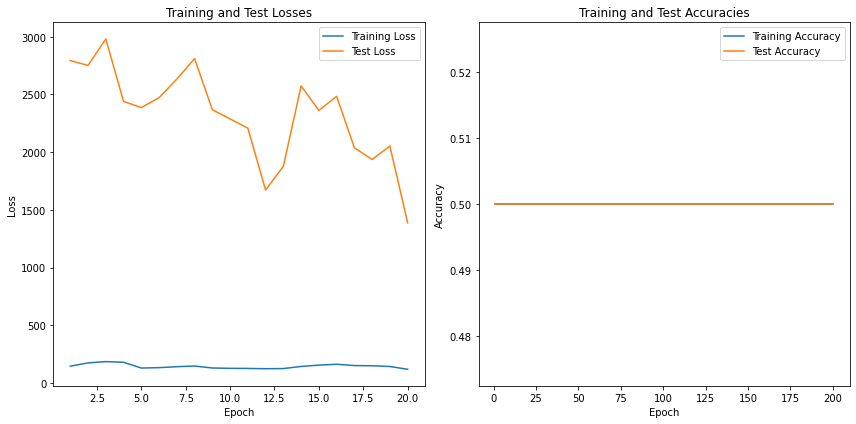

In [74]:
# Initialize lists to store training and test losses
train_losses = []
test_losses = []

# Initialize lists to store training and test accuracies
train_accuracies = []
test_accuracies = []

X_train = train_x
X_test = test_x
y_train = train_y
y_test = test_y

# Neural Network Parameters
input_size = 784
hidden_size1 = 64
hidden_size2 = 32
hidden_size3 = 16
output_size = 1  
learning_rate = 0.01
epochs = 200

# Initialize weights and biases
W1 = he_init(input_size, hidden_size1)
b1 = he_init(1, hidden_size1)
W2 = he_init(hidden_size1, hidden_size2)
b2 = he_init(1, hidden_size2)
W3 = he_init(hidden_size2, hidden_size3)
b3 = he_init(1, hidden_size3)
W4 = he_init(hidden_size3, output_size)
b4 = he_init(1, output_size)

batch_size = 64
epsilon = 1e-8

# Batch normalization parameters
gamma1 = np.ones((1, hidden_size1))
beta1 = np.zeros((1, hidden_size1))
gamma2 = np.ones((1, hidden_size2))
beta2 = np.zeros((1, hidden_size2))
gamma3 = np.ones((1, hidden_size3))
beta3 = np.zeros((1, hidden_size3))
gamma4 = np.ones((1, output_size))
beta4 = np.zeros((1, output_size))

# Training loop
for epoch in range(epochs):
    total_loss = 0.0  # Initialize total loss for the epoch
    for i in range(0, len(X_train), batch_size):
        # Forward propagation
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        z1 = np.dot(X_batch, W1) + b1
        z1_norm = (z1 - np.mean(z1, axis=0)) / np.sqrt(np.var(z1, axis=0) + epsilon)
        a1 = leaky_relu(gamma1 * z1_norm + beta1)

        z2 = np.dot(a1, W2) + b2
        z2_norm = (z2 - np.mean(z2, axis=0)) / np.sqrt(np.var(z2, axis=0) + epsilon)
        a2 = leaky_relu(gamma2 * z2_norm + beta2)
        
        z3 = np.dot(a2, W3) + b3
        z3_norm = (z3 - np.mean(z3, axis=0)) / np.sqrt(np.var(z3, axis=0) + epsilon)
        a3 = leaky_relu(gamma3 * z3_norm + beta3)

        z4 = np.dot(a3, W4) + b4
        z4_norm = (z4 - np.mean(z4, axis=0)) / np.sqrt(np.var(z4, axis=0) + epsilon)
        z4_clipped = np.clip(z4_norm, -500, 500)  # Clip values to prevent overflow
        a4 = sigmoid(gamma4 * z4_clipped + beta4)
        
        # Backpropagation
        delta4 = (a4 - y_batch.reshape(-1, 1)) * sigmoid_derivative(a4)
        dW4 = np.dot(a3.T, delta4)
        db4 = np.sum(delta4, axis=0, keepdims=True)
        delta3 = np.dot(delta4, W4.T) * leaky_relu_derivative(z3)
        dW3 = np.dot(a2.T, delta3)
        db3 = np.sum(delta3, axis=0)

        delta2 = np.dot(delta3, W3.T) * leaky_relu_derivative(z2)
        dW2 = np.dot(a1.T, delta2)
        db2 = np.sum(delta2, axis=0)

        delta1 = np.dot(delta2, W2.T) * leaky_relu_derivative(z1)
        dW1 = np.dot(X_batch.T, delta1)
        db1 = np.sum(delta1, axis=0)

        # Calculate loss for the current batch
        batch_loss = -np.sum(y_batch * np.log(a4) + (1 - y_batch) * np.log(1 - a4)) / len(X_batch)
        total_loss += batch_loss

        # Update weights and biases
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        W3 -= learning_rate * dW3
        b3 -= learning_rate * db3
        W4 -= learning_rate * dW4
        b4 -= learning_rate * db4
        
        # Update batch normalization parameters
        gamma1 -= learning_rate * np.sum(delta1 * z1_norm, axis=0)
        beta1 -= learning_rate * np.sum(delta1, axis=0)
        gamma2 -= learning_rate * np.sum(delta2 * z2_norm, axis=0)
        beta2 -= learning_rate * np.sum(delta2, axis=0)
        gamma3 -= learning_rate * np.sum(delta3 * z3_norm, axis=0)
        beta3 -= learning_rate * np.sum(delta3, axis=0)
        gamma4 -= learning_rate * np.sum(delta4 * z4_norm, axis=0)
        beta4 -= learning_rate * np.sum(delta4, axis=0)
        
        # Calculate loss for the current batch and add it to the total loss for the epoch
        batch_loss = -np.sum(y_batch * np.log(a4) + (1 - y_batch) * np.log(1 - a4)) / len(X_batch)
        total_loss += batch_loss
    
    # Average loss over all batches for the epoch
    avg_loss = total_loss / (len(X_train) / batch_size)
    train_losses.append(avg_loss)  # Store training loss for the epoch
    
    z1 = np.dot(X_train, W1) + b1
    a1 = leaky_relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = leaky_relu(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = leaky_relu(z3)
    z4 = np.dot(a3, W4) + b4
    a4_train = sigmoid(z4)
    
    # Calculate training accuracy for the epoch
    train_predictions = (a4_train > 0.5).astype(int)
    train_accuracy = np.mean(train_predictions == y_train)
    train_accuracies.append(train_accuracy)  # Store training accuracy for the epoch

    # Testing
    z1 = np.dot(X_test, W1) + b1
    a1 = leaky_relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = leaky_relu(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = leaky_relu(z3)
    z4 = np.dot(a3, W4) + b4
    z4_norm = (z4 - np.mean(z4, axis=0)) / np.sqrt(np.var(z4, axis=0) + epsilon)
    z4_clipped = np.clip(z4_norm, -500, 500)  # Clip values to prevent overflow
    a4 = sigmoid(gamma4 * z4_clipped + beta4)


    # Calculate test loss
    test_loss = -np.sum(y_test * np.log(a4) + (1 - y_test) * np.log(1 - a4)) / (len(X_test) + epsilon)
    test_losses.append(test_loss)  # Store test loss for the epoch
    
    # Calculate test accuracy
    test_predictions = (a4 > 0.5).astype(int)
    test_accuracy = np.mean(test_predictions == y_test)
    test_accuracies.append(test_accuracy)  # Store test accuracy for the epoch

    # Print average loss for the epoch
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')

# Plotting
plt.figure(figsize=(12, 6))

# Plot training and test losses
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

# Plot training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

sgd with momentum

Epoch 1/200, Average Loss: 103.49024360992985, Train Accuracy: 0.5, Test Accuracy: 0.5


<ipython-input-24-6643c91f08c4>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 2/200, Average Loss: 104.27210718397663, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 3/200, Average Loss: 105.19088519349604, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 4/200, Average Loss: 106.02779613995405, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 5/200, Average Loss: 106.90490024728089, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 6/200, Average Loss: 107.8526518865321, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 7/200, Average Loss: 109.06386203676382, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 8/200, Average Loss: 110.22951893348704, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 9/200, Average Loss: 111.4055882433612, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 10/200, Average Loss: 112.61090028093939, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 11/200, Average Loss: 114.16240382922012, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 12/200, Average Loss: 115.34177850637707, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 13/200, Average Loss: 116.2944065157

<ipython-input-52-c0ff1aa84ebb>:169: RuntimeWarning: invalid value encountered in subtract
  z4_norm = (z4 - np.mean(z4, axis=0)) / np.sqrt(np.var(z4, axis=0) + epsilon)


Epoch 15/200, Average Loss: 92.06071702480807, Train Accuracy: 0.5, Test Accuracy: 0.5


<ipython-input-52-c0ff1aa84ebb>:169: RuntimeWarning: invalid value encountered in divide
  z4_norm = (z4 - np.mean(z4, axis=0)) / np.sqrt(np.var(z4, axis=0) + epsilon)


Epoch 16/200, Average Loss: 92.2618947258871, Train Accuracy: 0.5, Test Accuracy: 0.5


<ipython-input-52-c0ff1aa84ebb>:69: RuntimeWarning: invalid value encountered in divide
  z2_norm = (z2 - np.mean(z2, axis=0)) / (np.sqrt(np.var(z2, axis=0)) + epsilon)
<ipython-input-52-c0ff1aa84ebb>:77: RuntimeWarning: invalid value encountered in divide
  z3_norm = (z3 - np.mean(z3, axis=0)) / (np.sqrt(np.var(z3, axis=0)) + epsilon)
<ipython-input-52-c0ff1aa84ebb>:83: RuntimeWarning: invalid value encountered in subtract
  z4_norm = (z4 - np.mean(z4, axis=0)) / (np.sqrt(np.var(z4, axis=0)) + epsilon)
<ipython-input-52-c0ff1aa84ebb>:106: RuntimeWarning: divide by zero encountered in log
  batch_loss = -np.sum(y_batch * np.log(a4) + (1 - y_batch) * np.log(1 - a4)) / len(X_batch)
<ipython-input-52-c0ff1aa84ebb>:106: RuntimeWarning: invalid value encountered in multiply
  batch_loss = -np.sum(y_batch * np.log(a4) + (1 - y_batch) * np.log(1 - a4)) / len(X_batch)
<ipython-input-52-c0ff1aa84ebb>:132: RuntimeWarning: overflow encountered in multiply
  gamma2 -= learning_rate * np.sum(delta2

Epoch 17/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 18/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 19/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 20/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 21/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 22/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 23/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 24/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 25/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 26/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 27/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 28/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 29/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 30/200, Average Loss: nan, Train Accuracy: 0.

Epoch 129/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 130/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 131/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 132/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 133/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 134/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 135/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 136/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 137/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 138/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 139/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 140/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 141/200, Average Loss: nan, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 142/200, Average Loss: nan, Trai

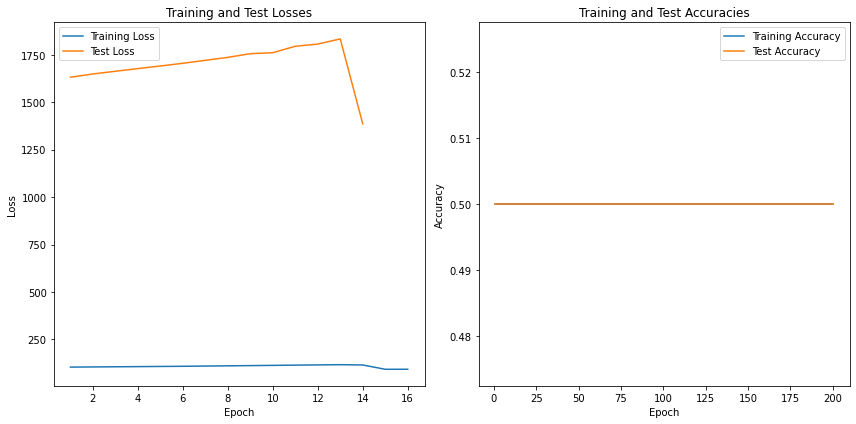

In [52]:
X_train = train_x
X_test = test_x
y_train = train_y
y_test = test_y

# Initialize lists to store training and test losses
train_losses = []
test_losses = []

# Initialize lists to store training and test accuracies
train_accuracies = []
test_accuracies = []

# Neural Network Parameters
input_size = 784
hidden_size1 = 64
hidden_size2 = 32
hidden_size3 = 16
output_size = 1  
learning_rate = 0.0001
epochs = 200

# Initialize weights and biases
W1 = random_init_s(input_size, hidden_size1)
b1 = random_init_s(1, hidden_size1)
W2 = random_init_s(hidden_size1, hidden_size2)
b2 = random_init_s(1, hidden_size2)
W3 = random_init_s(hidden_size2, hidden_size3)
b3 = random_init_s(1, hidden_size3)
W4 = random_init_s(hidden_size3, output_size)
b4 = random_init_s(1, output_size)

batch_size = 64
epsilon = 1e-15

# Batch normalization parameters
gamma1 = np.ones((1, hidden_size1))
beta1 = np.zeros((1, hidden_size1))
gamma2 = np.ones((1, hidden_size2))
beta2 = np.zeros((1, hidden_size2))
gamma3 = np.ones((1, hidden_size3))
beta3 = np.zeros((1, hidden_size3))
gamma4 = np.ones((1, output_size))
beta4 = np.zeros((1, output_size))

# Initialize momentum parameters
momentum = 0.9  # You can adjust this value (common values range from 0.8 to 0.999)
vW1, vb1 = 0, 0
vW2, vb2 = 0, 0
vW3, vb3 = 0, 0
vW4, vb4 = 0, 0

# Training loop
for epoch in range(epochs):
    total_loss = 0.0  # Initialize total loss for the epoch
    for i in range(0, len(X_train), batch_size):
        # Forward propagation
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        z1 = np.dot(X_batch, W1) + b1
        z1_norm = (z1 - np.mean(z1, axis=0)) / (np.sqrt(np.var(z1, axis=0)) + epsilon)
        a1 = leaky_relu(gamma1 * z1_norm + beta1)

        z2 = np.dot(a1, W2) + b2
#         z2_norm = (z2 - np.mean(z2, axis=0)) / (np.sqrt(np.var(z2, axis=0)) + epsilon)
#         test = np.sqrt(np.var(z2, axis=0))
#         if not (test.contains(0)):
        z2_norm = (z2 - np.mean(z2, axis=0)) / (np.sqrt(np.var(z2, axis=0)) + epsilon)  
#         else:
#             z2_norm = z2
        if(np.any(np.isnan(z2_norm))):
            z2_norm = z2
        a2 = leaky_relu(gamma2 * z2_norm + beta2)
        
        z3 = np.dot(a2, W3) + b3
        z3_norm = (z3 - np.mean(z3, axis=0)) / (np.sqrt(np.var(z3, axis=0)) + epsilon)
        if(np.any(np.isnan(z3_norm))):
            z3_norm = z3
        a3 = leaky_relu(gamma3 * z3_norm + beta3)

        z4 = np.dot(a3, W4) + b4
        z4_norm = (z4 - np.mean(z4, axis=0)) / (np.sqrt(np.var(z4, axis=0)) + epsilon)
#         z4_clipped = np.clip(z4_norm, -500, 500)  # Clip values to prevent overflow
        if(np.any(np.isnan(z4_norm))):
            z4_norm = z4
        a4 = sigmoid(gamma4 * z4_norm + beta4)
        
        # Backpropagation
        delta4 = (a4 - y_batch.reshape(-1, 1)) * sigmoid_derivative(a4)
        dW4 = np.dot(a3.T, delta4)
        db4 = np.sum(delta4, axis=0, keepdims=True)
        delta3 = np.dot(delta4, W4.T) * leaky_relu_derivative(z3)
        dW3 = np.dot(a2.T, delta3)
        db3 = np.sum(delta3, axis=0)

        delta2 = np.dot(delta3, W3.T) * leaky_relu_derivative(z2)
        dW2 = np.dot(a1.T, delta2)
        db2 = np.sum(delta2, axis=0)

        delta1 = np.dot(delta2, W2.T) * leaky_relu_derivative(z1)
        dW1 = np.dot(X_batch.T, delta1)
        db1 = np.sum(delta1, axis=0)

        # Calculate loss for the current batch
        batch_loss = -np.sum(y_batch * np.log(a4) + (1 - y_batch) * np.log(1 - a4)) / len(X_batch)
        total_loss += batch_loss

        # Update momentum terms
        vW4 = momentum * vW4 - learning_rate * dW4
        vb4 = momentum * vb4 - learning_rate * db4
        vW3 = momentum * vW3 - learning_rate * dW3
        vb3 = momentum * vb3 - learning_rate * db3
        vW2 = momentum * vW2 - learning_rate * dW2
        vb2 = momentum * vb2 - learning_rate * db2
        vW1 = momentum * vW1 - learning_rate * dW1
        vb1 = momentum * vb1 - learning_rate * db1

        # Update weights and biases using momentum
        W1 += vW1
        b1 += vb1
        W2 += vW2
        b2 += vb2
        W3 += vW3
        b3 += vb3
        W4 += vW4
        b4 += vb4

        # Update batch normalization parameters
        gamma1 -= learning_rate * np.sum(delta1 * z1_norm, axis=0)
        beta1 -= learning_rate * np.sum(delta1, axis=0)
        gamma2 -= learning_rate * np.sum(delta2 * z2_norm, axis=0)
        beta2 -= learning_rate * np.sum(delta2, axis=0)
        gamma3 -= learning_rate * np.sum(delta3 * z3_norm, axis=0)
        beta3 -= learning_rate * np.sum(delta3, axis=0)
        gamma4 -= learning_rate * np.sum(delta4 * z4_norm, axis=0)
        beta4 -= learning_rate * np.sum(delta4, axis=0)
        
        # Calculate loss for the current batch and add it to the total loss for the epoch
        batch_loss = -np.sum(y_batch * np.log(a4) + (1 - y_batch) * np.log(1 - a4)) / len(X_batch)
        total_loss += batch_loss
    
    # Average loss over all batches for the epoch
    avg_loss = total_loss / (len(X_train) / batch_size)
    train_losses.append(avg_loss)  # Store training loss for the epoch
    
    z1 = np.dot(X_train, W1) + b1
    a1 = leaky_relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = leaky_relu(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = leaky_relu(z3)
    z4 = np.dot(a3, W4) + b4
    a4_train = sigmoid(z4)
    
    # Calculate training accuracy for the epoch
    train_predictions = (a4_train > 0.5).astype(int)
    train_accuracy = np.mean(train_predictions == y_train)
    train_accuracies.append(train_accuracy)  # Store training accuracy for the epoch

    # Testing
    z1 = np.dot(X_test, W1) + b1
    a1 = leaky_relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = leaky_relu(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = leaky_relu(z3)
    z4 = np.dot(a3, W4) + b4
    z4_norm = (z4 - np.mean(z4, axis=0)) / np.sqrt(np.var(z4, axis=0) + epsilon)
    z4_clipped = np.clip(z4_norm, -500, 500)  # Clip values to prevent overflow
    a4 = sigmoid(gamma4 * z4_clipped + beta4)

    # Calculate test loss
    test_loss = -np.sum(y_test * np.log(a4) + (1 - y_test) * np.log(1 - a4)) / (len(X_test) + epsilon)
    test_losses.append(test_loss)  # Store test loss for the epoch
    
    # Calculate test accuracy
    test_predictions = (a4 > 0.5).astype(int)
    test_accuracy = np.mean(test_predictions == y_test)
    test_accuracies.append(test_accuracy)  # Store test accuracy for the epoch

    # Print average loss for the epoch
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')

# Plotting
plt.figure(figsize=(12, 6))

# Plot training and test losses
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

# Plot training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies')
plt.legend()

plt.tight_layout()
plt.show()


RMSprop

Epoch 1/200, Average Loss: 106.72179537591202, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 2/200, Average Loss: 116.37537513394216, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 3/200, Average Loss: 127.91410541921617, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 4/200, Average Loss: 138.9111921356509, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 5/200, Average Loss: 148.74468406531372, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 6/200, Average Loss: 157.5634843141185, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 7/200, Average Loss: 165.5521082266035, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 8/200, Average Loss: 172.8359484636033, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 9/200, Average Loss: 179.5441996366121, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 10/200, Average Loss: 185.73664714993083, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 11/200, Average Loss: 191.4123461961985, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 12/200, Average Loss: 196.62357222094082,

Epoch 95/200, Average Loss: 333.82565014347597, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 96/200, Average Loss: 334.4840127673737, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 97/200, Average Loss: 335.13423445296235, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 98/200, Average Loss: 335.7769162227847, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 99/200, Average Loss: 336.41162421613103, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 100/200, Average Loss: 337.03846305681327, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 101/200, Average Loss: 337.6580779659783, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 102/200, Average Loss: 338.2697719667108, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 103/200, Average Loss: 338.875110703912, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 104/200, Average Loss: 339.47383075888706, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 105/200, Average Loss: 340.0650032842012, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 106/200, Average Loss: 340.

Epoch 188/200, Average Loss: 372.89151291488105, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 189/200, Average Loss: 373.15640009066044, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 190/200, Average Loss: 373.41868189362856, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 191/200, Average Loss: 373.6787973515215, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 192/200, Average Loss: 373.93697971793887, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 193/200, Average Loss: 374.19293083907723, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 194/200, Average Loss: 374.4468989092876, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 195/200, Average Loss: 374.6988701215749, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 196/200, Average Loss: 374.94870524385, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 197/200, Average Loss: 375.19651352943544, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 198/200, Average Loss: 375.44247732476947, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 199/200, Average Loss

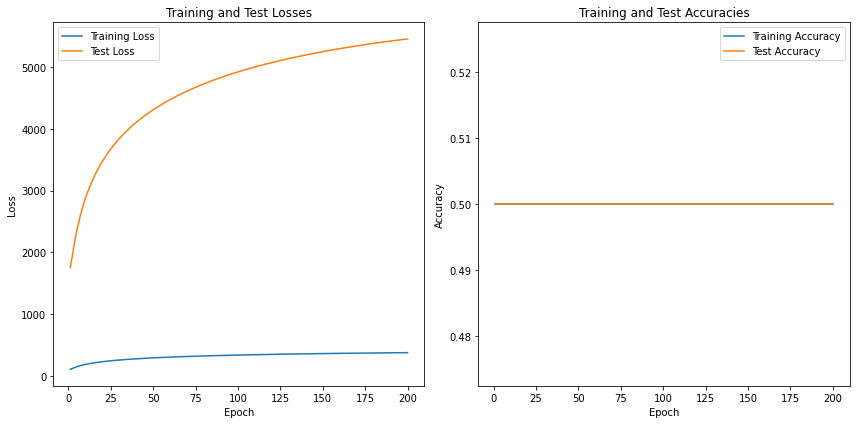

In [91]:
# Initialize lists to store training and test losses
train_losses = []
test_losses = []

# Initialize lists to store training and test accuracies
train_accuracies = []
test_accuracies = []

X_train = train_x
X_test = test_x
y_train = train_y
y_test = test_y

# Neural Network Parameters
input_size = 784
hidden_size1 = 128
hidden_size2 = 64
hidden_size3 = 32
output_size = 1  
learning_rate = 0.001
epochs = 200

# Initialize weights and biases
# W1 = he_init(input_size, hidden_size1)
# b1 = he_init(1, hidden_size1)
# W2 = he_init(hidden_size1, hidden_size2)
# b2 = he_init(1, hidden_size2)
# W3 = he_init(hidden_size2, hidden_size3)
# b3 = he_init(1, hidden_size3)
# W4 = he_init(hidden_size3, output_size)
# b4 = he_init(1, output_size)
W1 = random_init_s(input_size, hidden_size1)
b1 = random_init_s(1, hidden_size1)
W2 = random_init_s(hidden_size1, hidden_size2)
b2 = random_init_s(1, hidden_size2)
W3 = random_init_s(hidden_size2, hidden_size3)
b3 = random_init_s(1, hidden_size3)
W4 = random_init_s(hidden_size3, output_size)
b4 = random_init_s(1, output_size)

batch_size = 64
epsilon = 1e-8
decay_rate = 0.9  # Decay rate for the moving average of squared gradients

# Batch normalization parameters
gamma1 = np.ones((1, hidden_size1))
beta1 = np.zeros((1, hidden_size1))
gamma2 = np.ones((1, hidden_size2))
beta2 = np.zeros((1, hidden_size2))
gamma3 = np.ones((1, hidden_size3))
beta3 = np.zeros((1, hidden_size3))
gamma4 = np.ones((1, output_size))
beta4 = np.zeros((1, output_size))

# Initialize squared gradients
squared_grad_W1 = np.zeros_like(W1)
squared_grad_b1 = np.zeros_like(b1)
squared_grad_W2 = np.zeros_like(W2)
squared_grad_b2 = np.zeros_like(b2)
squared_grad_W3 = np.zeros_like(W3)
squared_grad_b3 = np.zeros_like(b3)
squared_grad_W4 = np.zeros_like(W4)
squared_grad_b4 = np.zeros_like(b4)

# Training loop
for epoch in range(epochs):
    total_loss = 0.0  # Initialize total loss for the epoch
    for i in range(0, len(X_train), batch_size):
        # Forward propagation
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        z1 = np.dot(X_batch, W1) + b1
        z1_norm = (z1 - np.mean(z1, axis=0)) / np.sqrt(np.var(z1, axis=0) + epsilon)
        a1 = leaky_relu(gamma1 * z1_norm + beta1)

        z2 = np.dot(a1, W2) + b2
        z2_norm = (z2 - np.mean(z2, axis=0)) / np.sqrt(np.var(z2, axis=0) + epsilon)
        a2 = leaky_relu(gamma2 * z2_norm + beta2)
        
        z3 = np.dot(a2, W3) + b3
        z3_norm = (z3 - np.mean(z3, axis=0)) / np.sqrt(np.var(z3, axis=0) + epsilon)
        a3 = leaky_relu(gamma3 * z3_norm + beta3)

        z4 = np.dot(a3, W4) + b4
        z4_norm = (z4 - np.mean(z4, axis=0)) / np.sqrt(np.var(z4, axis=0) + epsilon)
        z4_clipped = np.clip(z4_norm, -500, 500)  # Clip values to prevent overflow
        a4 = sigmoid(gamma4 * z4_clipped + beta4)
        
        # Backpropagation
        delta4 = (a4 - y_batch.reshape(-1, 1)) * sigmoid_derivative(a4)
        dW4 = np.dot(a3.T, delta4)
        db4 = np.sum(delta4, axis=0, keepdims=True)
        delta3 = np.dot(delta4, W4.T) * leaky_relu_derivative(z3)
        dW3 = np.dot(a2.T, delta3)
        db3 = np.sum(delta3, axis=0)

        delta2 = np.dot(delta3, W3.T) * leaky_relu_derivative(z2)
        dW2 = np.dot(a1.T, delta2)
        db2 = np.sum(delta2, axis=0)

        delta1 = np.dot(delta2, W2.T) * leaky_relu_derivative(z1)
        dW1 = np.dot(X_batch.T, delta1)
        db1 = np.sum(delta1, axis=0)

        # Calculate loss for the current batch
        batch_loss = -np.sum(y_batch * np.log(a4) + (1 - y_batch) * np.log(1 - a4)) / len(X_batch)
        total_loss += batch_loss

        # Update squared gradients
        squared_grad_W4 = decay_rate * squared_grad_W4 + (1 - decay_rate) * dW4 ** 2
        squared_grad_b4 = decay_rate * squared_grad_b4 + (1 - decay_rate) * db4 ** 2
        squared_grad_W3 = decay_rate * squared_grad_W3 + (1 - decay_rate) * dW3 ** 2
        squared_grad_b3 = decay_rate * squared_grad_b3 + (1 - decay_rate) * db3 ** 2
        squared_grad_W2 = decay_rate * squared_grad_W2 + (1 - decay_rate) * dW2 ** 2
        squared_grad_b2 = decay_rate * squared_grad_b2 + (1 - decay_rate) * db2 ** 2
        squared_grad_W1 = decay_rate * squared_grad_W1 + (1 - decay_rate) * dW1 ** 2
        squared_grad_b1 = decay_rate * squared_grad_b1 + (1 - decay_rate) * db1 ** 2

        # Update weights and biases using RMSprop
        W1 -= learning_rate * dW1 / (np.sqrt(squared_grad_W1) + epsilon)
        b1 -= learning_rate * db1 / (np.sqrt(squared_grad_b1) + epsilon)
        W2 -= learning_rate * dW2 / (np.sqrt(squared_grad_W2) + epsilon)
        b2 -= learning_rate * db2 / (np.sqrt(squared_grad_b2) + epsilon)
        W3 -= learning_rate * dW3 / (np.sqrt(squared_grad_W3) + epsilon)
        b3 -= learning_rate * db3 / (np.sqrt(squared_grad_b3) + epsilon)
        W4 -= learning_rate * dW4 / (np.sqrt(squared_grad_W4) + epsilon)
        b4 -= learning_rate * db4 / (np.sqrt(squared_grad_b4) + epsilon)

        # Update batch normalization parameters
        gamma1 -= learning_rate * np.sum(delta1 * z1_norm, axis=0)
        beta1 -= learning_rate * np.sum(delta1, axis=0)
        gamma2 -= learning_rate * np.sum(delta2 * z2_norm, axis=0)
        beta2 -= learning_rate * np.sum(delta2, axis=0)
        gamma3 -= learning_rate * np.sum(delta3 * z3_norm, axis=0)
        beta3 -= learning_rate * np.sum(delta3, axis=0)
        gamma4 -= learning_rate * np.sum(delta4 * z4_norm, axis=0)
        beta4 -= learning_rate * np.sum(delta4, axis=0)
        
        # Calculate loss for the current batch and add it to the total loss for the epoch
        batch_loss = -np.sum(y_batch * np.log(a4) + (1 - y_batch) * np.log(1 - a4)) / len(X_batch)
        total_loss += batch_loss
    
    # Average loss over all batches for the epoch
    avg_loss = total_loss / (len(X_train) / batch_size)
    train_losses.append(avg_loss)  # Store training loss for the epoch
    
    z1 = np.dot(X_train, W1) + b1
    a1 = leaky_relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = leaky_relu(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = leaky_relu(z3)
    z4 = np.dot(a3, W4) + b4
    a4_train = sigmoid(z4)
    
    # Calculate training accuracy for the epoch
    train_predictions = (a4_train > 0.5).astype(int)
    train_accuracy = np.mean(train_predictions == y_train)
    train_accuracies.append(train_accuracy)  # Store training accuracy for the epoch

    # Testing
    z1 = np.dot(X_test, W1) + b1
    a1 = leaky_relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = leaky_relu(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = leaky_relu(z3)
    z4 = np.dot(a3, W4) + b4
    z4_norm = (z4 - np.mean(z4, axis=0)) / np.sqrt(np.var(z4, axis=0) + epsilon)
    z4_clipped = np.clip(z4_norm, -500, 500)  # Clip values to prevent overflow
    a4 = sigmoid(gamma4 * z4_clipped + beta4)


    # Calculate test loss
    test_loss = -np.sum(y_test * np.log(a4) + (1 - y_test) * np.log(1 - a4)) / (len(X_test) + epsilon)
    test_losses.append(test_loss)  # Store test loss for the epoch
    
    # Calculate test accuracy
    test_predictions = (a4 > 0.5).astype(int)
    test_accuracy = np.mean(test_predictions == y_test)
    test_accuracies.append(test_accuracy)  # Store test accuracy for the epoch

    # Print average loss for the epoch
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')

# Plotting
plt.figure(figsize=(12, 6))

# Plot training and test losses
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

# Plot training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

ADAM

<ipython-input-54-7ab6cdd684c2>:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 1/200, Average Loss: 149.3181915939034, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 2/200, Average Loss: 209.89455703317847, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 3/200, Average Loss: 242.389368313341, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 4/200, Average Loss: 265.30138406209386, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 5/200, Average Loss: 283.0115861404527, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 6/200, Average Loss: 297.3639587948431, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 7/200, Average Loss: 309.2690486877711, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 8/200, Average Loss: 319.3221745684741, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 9/200, Average Loss: 327.9544166608992, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 10/200, Average Loss: 335.46871519606515, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 11/200, Average Loss: 342.1008675866383, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 12/200, Average Loss: 348.0142207027631, Tra

Epoch 95/200, Average Loss: 446.70135268863083, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 96/200, Average Loss: 447.0608809339221, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 97/200, Average Loss: 447.416059240757, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 98/200, Average Loss: 447.7673136355404, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 99/200, Average Loss: 448.1153757526495, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 100/200, Average Loss: 448.4597810640748, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 101/200, Average Loss: 448.80014199458077, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 102/200, Average Loss: 449.1360905916787, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 103/200, Average Loss: 449.4684891096651, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 104/200, Average Loss: 449.79780411301016, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 105/200, Average Loss: 450.1242908902724, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 106/200, Average Loss: 450.44

Epoch 188/200, Average Loss: 471.84720810531707, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 189/200, Average Loss: 472.09408977239934, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 190/200, Average Loss: 472.34403605235764, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 191/200, Average Loss: 472.59568411650014, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 192/200, Average Loss: 472.8492189525573, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 193/200, Average Loss: 473.10737961220946, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 194/200, Average Loss: 473.3726625132078, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 195/200, Average Loss: 473.6448351796938, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 196/200, Average Loss: 473.92302521028546, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 197/200, Average Loss: 474.2031983313007, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 198/200, Average Loss: 474.4845622172847, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 199/200, Average Los

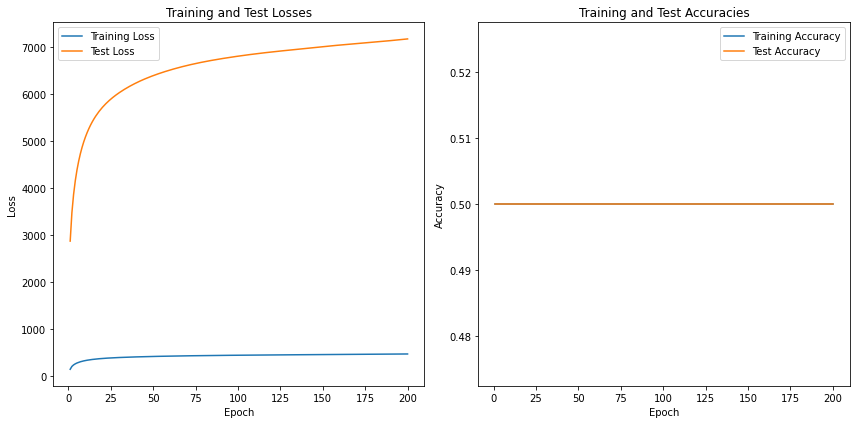

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Define activation functions and their derivatives
def leaky_relu(x):
    return np.maximum(0.1 * x, x)

def leaky_relu_derivative(x):
    dx = np.ones_like(x)
    dx[x < 0] *= 0.1
    return dx

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Initialize weights using He initialization
def he_init(input_size, output_size):
    return np.random.randn(input_size, output_size) * np.sqrt(2.0 / input_size)

# Initialize lists to store training and test losses
train_losses = []
test_losses = []

# Initialize lists to store training and test accuracies
train_accuracies = []
test_accuracies = []

X_train = train_x
X_test = test_x
y_train = train_y
y_test = test_y

# Neural Network Parameters
input_size = 784
hidden_size1 = 64
hidden_size2 = 32
hidden_size3 = 16
output_size = 1  
learning_rate = 0.01
epochs = 200

# Initialize weights and biases
W1 = he_init(input_size, hidden_size1)
b1 = he_init(1, hidden_size1)
W2 = he_init(hidden_size1, hidden_size2)
b2 = he_init(1, hidden_size2)
W3 = he_init(hidden_size2, hidden_size3)
b3 = he_init(1, hidden_size3)
W4 = he_init(hidden_size3, output_size)
b4 = he_init(1, output_size)

batch_size = 64
epsilon = 1e-8
beta1_adam = 0.9  # Decay rate for the first moment estimate in Adam
beta2_adam = 0.999  # Decay rate for the second moment estimate in Adam

# Batch normalization parameters
gamma1 = np.ones((1, hidden_size1))
beta1_bn = np.zeros((1, hidden_size1))
gamma2 = np.ones((1, hidden_size2))
beta2_bn = np.zeros((1, hidden_size2))
gamma3 = np.ones((1, hidden_size3))
beta3_bn = np.zeros((1, hidden_size3))
gamma4 = np.ones((1, output_size))
beta4_bn = np.zeros((1, output_size))

# Initialize moment estimates for Adam
m_W1, m_b1 = 0, 0
m_W2, m_b2 = 0, 0
m_W3, m_b3 = 0, 0
m_W4, m_b4 = 0, 0
v_W1, v_b1 = 0, 0
v_W2, v_b2 = 0, 0
v_W3, v_b3 = 0, 0
v_W4, v_b4 = 0, 0

# Training loop
for epoch in range(epochs):
    total_loss = 0.0  # Initialize total loss for the epoch
    for i in range(0, len(X_train), batch_size):
        # Forward propagation
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        z1 = np.dot(X_batch, W1) + b1
        z1_norm = (z1 - np.mean(z1, axis=0)) / np.sqrt(np.var(z1, axis=0) + epsilon)
        a1 = leaky_relu(gamma1 * z1_norm + beta1_bn)

        z2 = np.dot(a1, W2) + b2
        z2_norm = (z2 - np.mean(z2, axis=0)) / np.sqrt(np.var(z2, axis=0) + epsilon)
        a2 = leaky_relu(gamma2 * z2_norm + beta2_bn)
        
        z3 = np.dot(a2, W3) + b3
        z3_norm = (z3 - np.mean(z3, axis=0)) / np.sqrt(np.var(z3, axis=0) + epsilon)
        a3 = leaky_relu(gamma3 * z3_norm + beta3_bn)

        z4 = np.dot(a3, W4) + b4
        z4_norm = (z4 - np.mean(z4, axis=0)) / np.sqrt(np.var(z4, axis=0) + epsilon)
        z4_clipped = np.clip(z4_norm, -500, 500)  # Clip values to prevent overflow
        a4 = sigmoid(gamma4 * z4_clipped + beta4_bn)
        
        # Backpropagation
        delta4 = (a4 - y_batch.reshape(-1, 1)) * sigmoid_derivative(a4)
        dW4 = np.dot(a3.T, delta4)
        db4 = np.sum(delta4, axis=0, keepdims=True)
        delta3 = np.dot(delta4, W4.T) * leaky_relu_derivative(z3)
        dW3 = np.dot(a2.T, delta3)
        db3 = np.sum(delta3, axis=0)

        delta2 = np.dot(delta3, W3.T) * leaky_relu_derivative(z2)
        dW2 = np.dot(a1.T, delta2)
        db2 = np.sum(delta2, axis=0)

        delta1 = np.dot(delta2, W2.T) * leaky_relu_derivative(z1)
        dW1 = np.dot(X_batch.T, delta1)
        db1 = np.sum(delta1, axis=0)

        # Calculate loss for the current batch
        batch_loss = -np.sum(y_batch * np.log(a4) + (1 - y_batch) * np.log(1 - a4)) / len(X_batch)
        total_loss += batch_loss

        # Update moment estimates for Adam
        m_W4 = beta1_adam * m_W4 + (1 - beta1_adam) * dW4
        m_b4 = beta1_adam * m_b4 + (1 - beta1_adam) * db4
        v_W4 = beta2_adam * v_W4 + (1 - beta2_adam) * (dW4 ** 2)
        v_b4 = beta2_adam * v_b4 + (1 - beta2_adam) * (db4 ** 2)
        m_W3 = beta1_adam * m_W3 + (1 - beta1_adam) * dW3
        m_b3 = beta1_adam * m_b3 + (1 - beta1_adam) * db3
        v_W3 = beta2_adam * v_W3 + (1 - beta2_adam) * (dW3 ** 2)
        v_b3 = beta2_adam * v_b3 + (1 - beta2_adam) * (db3 ** 2)
        m_W2 = beta1_adam * m_W2 + (1 - beta1_adam) * dW2
        m_b2 = beta1_adam * m_b2 + (1 - beta1_adam) * db2
        v_W2 = beta2_adam * v_W2 + (1 - beta2_adam) * (dW2 ** 2)
        v_b2 = beta2_adam * v_b2 + (1 - beta2_adam) * (db2 ** 2)
        m_W1 = beta1_adam * m_W1 + (1 - beta1_adam) * dW1
        m_b1 = beta1_adam * m_b1 + (1 - beta1_adam) * db1
        v_W1 = beta2_adam * v_W1 + (1 - beta2_adam) * (dW1 ** 2)
        v_b1 = beta2_adam * v_b1 + (1 - beta2_adam) * (db1 ** 2)

        # Bias correction for moment estimates
        m_W4_corrected = m_W4 / (1 - beta1_adam ** (epoch + 1))
        m_b4_corrected = m_b4 / (1 - beta1_adam ** (epoch + 1))
        v_W4_corrected = v_W4 / (1 - beta2_adam ** (epoch + 1))
        v_b4_corrected = v_b4 / (1 - beta2_adam ** (epoch + 1))
        m_W3_corrected = m_W3 / (1 - beta1_adam ** (epoch + 1))
        m_b3_corrected = m_b3 / (1 - beta1_adam ** (epoch + 1))
        v_W3_corrected = v_W3 / (1 - beta2_adam ** (epoch + 1))
        v_b3_corrected = v_b3 / (1 - beta2_adam ** (epoch + 1))
        m_W2_corrected = m_W2 / (1 - beta1_adam ** (epoch + 1))
        m_b2_corrected = m_b2 / (1 - beta1_adam ** (epoch + 1))
        v_W2_corrected = v_W2 / (1 - beta2_adam ** (epoch + 1))
        v_b2_corrected = v_b2 / (1 - beta2_adam ** (epoch + 1))
        m_W1_corrected = m_W1 / (1 - beta1_adam ** (epoch + 1))
        m_b1_corrected = m_b1 / (1 - beta1_adam ** (epoch + 1))
        v_W1_corrected = v_W1 / (1 - beta2_adam ** (epoch + 1))
        v_b1_corrected = v_b1 / (1 - beta2_adam ** (epoch + 1))

        # Update weights and biases using Adam with bias correction
        W1 -= learning_rate * m_W1_corrected / (np.sqrt(v_W1_corrected) + epsilon)
        b1 -= learning_rate * m_b1_corrected / (np.sqrt(v_b1_corrected) + epsilon)
        W2 -= learning_rate * m_W2_corrected / (np.sqrt(v_W2_corrected) + epsilon)
        b2 -= learning_rate * m_b2_corrected / (np.sqrt(v_b2_corrected) + epsilon)
        W3 -= learning_rate * m_W3_corrected / (np.sqrt(v_W3_corrected) + epsilon)
        b3 -= learning_rate * m_b3_corrected / (np.sqrt(v_b3_corrected) + epsilon)
        W4 -= learning_rate * m_W4_corrected / (np.sqrt(v_W4_corrected) + epsilon)
        b4 -= learning_rate * m_b4_corrected / (np.sqrt(v_b4_corrected) + epsilon)

        # Update batch normalization parameters
        gamma1 -= learning_rate * np.sum(delta1 * z1_norm, axis=0)
        beta1_bn -= learning_rate * np.sum(delta1, axis=0)
        gamma2 -= learning_rate * np.sum(delta2 * z2_norm, axis=0)
        beta2_bn -= learning_rate * np.sum(delta2, axis=0)
        gamma3 -= learning_rate * np.sum(delta3 * z3_norm, axis=0)
        beta3_bn -= learning_rate * np.sum(delta3, axis=0)
        gamma4 -= learning_rate * np.sum(delta4 * z4_norm, axis=0)
        beta4_bn -= learning_rate * np.sum(delta4, axis=0)
        
        # Calculate loss for the current batch and add it to the total loss for the epoch
        batch_loss = -np.sum(y_batch * np.log(a4) + (1 - y_batch) * np.log(1 - a4)) / len(X_batch)
        total_loss += batch_loss
    
    # Average loss over all batches for the epoch
    avg_loss = total_loss / (len(X_train) / batch_size)
    train_losses.append(avg_loss)  # Store training loss for the epoch
    
    z1 = np.dot(X_train, W1) + b1
    a1 = leaky_relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = leaky_relu(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = leaky_relu(z3)
    z4 = np.dot(a3, W4) + b4
    a4_train = sigmoid(z4)
    
    # Calculate training accuracy for the epoch
    train_predictions = (a4_train > 0.5).astype(int)
    train_accuracy = np.mean(train_predictions == y_train)
    train_accuracies.append(train_accuracy)  # Store training accuracy for the epoch

    # Testing
    z1 = np.dot(X_test, W1) + b1
    a1 = leaky_relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = leaky_relu(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = leaky_relu(z3)
    z4 = np.dot(a3, W4) + b4
    z4_norm = (z4 - np.mean(z4, axis=0)) / np.sqrt(np.var(z4, axis=0) + epsilon)
    z4_clipped = np.clip(z4_norm, -500, 500)  # Clip values to prevent overflow
    a4 = sigmoid(gamma4 * z4_clipped + beta4_bn)


    # Calculate test loss
    test_loss = -np.sum(y_test * np.log(a4) + (1 - y_test) * np.log(1 - a4)) / (len(X_test) + epsilon)
    test_losses.append(test_loss)  # Store test loss for the epoch
    
    # Calculate test accuracy
    test_predictions = (a4 > 0.5).astype(int)
    test_accuracy = np.mean(test_predictions == y_test)
    test_accuracies.append(test_accuracy)  # Store test accuracy for the epoch

    # Print average loss for the epoch
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')

# Plotting
plt.figure(figsize=(12, 6))

# Plot training and test losses
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

# Plot training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/200, Average Loss: 103.22530426761969, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 2/200, Average Loss: 103.22547954668205, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 3/200, Average Loss: 103.2255264057531, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 4/200, Average Loss: 103.22553597720076, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 5/200, Average Loss: 103.22552738981642, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 6/200, Average Loss: 103.22550821799167, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 7/200, Average Loss: 103.2254823736646, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 8/200, Average Loss: 103.22545206167999, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 9/200, Average Loss: 103.22541870053318, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 10/200, Average Loss: 103.22538318557758, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 11/200, Average Loss: 103.22534617234976, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 12/200, Average Loss: 103.22530813429

Epoch 95/200, Average Loss: 103.2243647979801, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 96/200, Average Loss: 103.22438542003931, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 97/200, Average Loss: 103.22440664595517, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 98/200, Average Loss: 103.2244284641385, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 99/200, Average Loss: 103.22445105666718, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 100/200, Average Loss: 103.22447432161452, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 101/200, Average Loss: 103.22449811321542, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 102/200, Average Loss: 103.22452238855583, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 103/200, Average Loss: 103.22454718319129, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 104/200, Average Loss: 103.22457257945507, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 105/200, Average Loss: 103.22459875664791, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 106/200, Average Loss:

Epoch 188/200, Average Loss: 103.22883998572847, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 189/200, Average Loss: 103.22891423912868, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 190/200, Average Loss: 103.22898873729234, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 191/200, Average Loss: 103.2290637201279, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 192/200, Average Loss: 103.22913934987128, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 193/200, Average Loss: 103.22921540682802, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 194/200, Average Loss: 103.229291623738, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 195/200, Average Loss: 103.229368296611, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 196/200, Average Loss: 103.22944544900679, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 197/200, Average Loss: 103.22952274744121, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 198/200, Average Loss: 103.22960040328375, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 199/200, Average Los

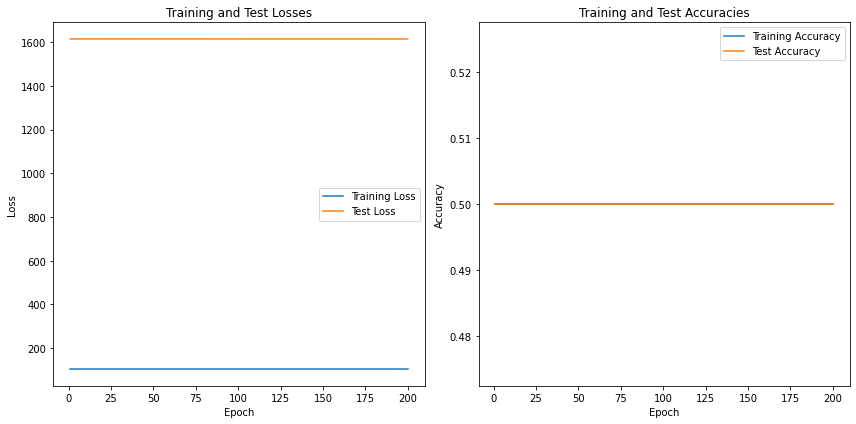

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Define activation functions and their derivatives
def leaky_relu(x):
    return np.maximum(0.1 * x, x)

def leaky_relu_derivative(x):
    dx = np.ones_like(x)
    dx[x < 0] *= 0.1
    return dx

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Initialize weights using He initialization
def he_init(input_size, output_size):
    return np.random.randn(input_size, output_size) * np.sqrt(2.0 / input_size)

# Initialize lists to store training and test losses
train_losses = []
test_losses = []

# Initialize lists to store training and test accuracies
train_accuracies = []
test_accuracies = []

X_train = train_x
X_test = test_x
y_train = train_y
y_test = test_y

# Neural Network Parameters
input_size = 784
hidden_size1 = 64
hidden_size2 = 32
hidden_size3 = 16
output_size = 1  
learning_rate = 0.00000001
epochs = 200

# Initialize weights and biases
W1 = he_init(input_size, hidden_size1)
b1 = he_init(1, hidden_size1)
W2 = he_init(hidden_size1, hidden_size2)
b2 = he_init(1, hidden_size2)
W3 = he_init(hidden_size2, hidden_size3)
b3 = he_init(1, hidden_size3)
W4 = he_init(hidden_size3, output_size)
b4 = he_init(1, output_size)

batch_size = 64
epsilon = 1e-8
beta1_adam = 0.9  # Decay rate for the first moment estimate in Adam
beta2_adam = 0.999  # Decay rate for the second moment estimate in Adam

# Batch normalization parameters
gamma1 = np.ones((1, hidden_size1))
beta1_bn = np.zeros((1, hidden_size1))
gamma2 = np.ones((1, hidden_size2))
beta2_bn = np.zeros((1, hidden_size2))
gamma3 = np.ones((1, hidden_size3))
beta3_bn = np.zeros((1, hidden_size3))
gamma4 = np.ones((1, output_size))
beta4_bn = np.zeros((1, output_size))

# Initialize moment estimates for Adam
m_W1, m_b1 = 0, 0
m_W2, m_b2 = 0, 0
m_W3, m_b3 = 0, 0
m_W4, m_b4 = 0, 0
v_W1, v_b1 = 0, 0
v_W2, v_b2 = 0, 0
v_W3, v_b3 = 0, 0
v_W4, v_b4 = 0, 0

# Training loop
for epoch in range(epochs):
    total_loss = 0.0  # Initialize total loss for the epoch
    for i in range(0, len(X_train), batch_size):
        # Forward propagation
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        z1 = np.dot(X_batch, W1) + b1
        z1_norm = (z1 - np.mean(z1, axis=0)) / np.sqrt(np.var(z1, axis=0) + epsilon)
        a1 = leaky_relu(gamma1 * z1_norm + beta1_bn)

        z2 = np.dot(a1, W2) + b2
        z2_norm = (z2 - np.mean(z2, axis=0)) / np.sqrt(np.var(z2, axis=0) + epsilon)
        a2 = leaky_relu(gamma2 * z2_norm + beta2_bn)
        
        z3 = np.dot(a2, W3) + b3
        z3_norm = (z3 - np.mean(z3, axis=0)) / np.sqrt(np.var(z3, axis=0) + epsilon)
        a3 = leaky_relu(gamma3 * z3_norm + beta3_bn)

        z4 = np.dot(a3, W4) + b4
        z4_norm = (z4 - np.mean(z4, axis=0)) / np.sqrt(np.var(z4, axis=0) + epsilon)
        z4_clipped = np.clip(z4_norm, -500, 500)  # Clip values to prevent overflow
        a4 = sigmoid(gamma4 * z4_clipped + beta4_bn)
        
        # Backpropagation
        delta4 = (a4 - y_batch.reshape(-1, 1)) * sigmoid_derivative(a4)
        dW4 = np.dot(a3.T, delta4)
        db4 = np.sum(delta4, axis=0, keepdims=True)
        delta3 = np.dot(delta4, W4.T) * leaky_relu_derivative(z3)
        dW3 = np.dot(a2.T, delta3)
        db3 = np.sum(delta3, axis=0)

        delta2 = np.dot(delta3, W3.T) * leaky_relu_derivative(z2)
        dW2 = np.dot(a1.T, delta2)
        db2 = np.sum(delta2, axis=0)

        delta1 = np.dot(delta2, W2.T) * leaky_relu_derivative(z1)
        dW1 = np.dot(X_batch.T, delta1)
        db1 = np.sum(delta1, axis=0)

        # Calculate loss for the current batch
        batch_loss = -np.sum(y_batch * np.log(a4) + (1 - y_batch) * np.log(1 - a4)) / len(X_batch)
        total_loss += batch_loss

        # Update moment estimates for Adam
        m_W4 = beta1_adam * m_W4 + (1 - beta1_adam) * dW4
        m_b4 = beta1_adam * m_b4 + (1 - beta1_adam) * db4
        v_W4 = beta2_adam * v_W4 + (1 - beta2_adam) * (dW4 ** 2)
        v_b4 = beta2_adam * v_b4 + (1 - beta2_adam) * (db4 ** 2)
        m_W3 = beta1_adam * m_W3 + (1 - beta1_adam) * dW3
        m_b3 = beta1_adam * m_b3 + (1 - beta1_adam) * db3
        v_W3 = beta2_adam * v_W3 + (1 - beta2_adam) * (dW3 ** 2)
        v_b3 = beta2_adam * v_b3 + (1 - beta2_adam) * (db3 ** 2)
        m_W2 = beta1_adam * m_W2 + (1 - beta1_adam) * dW2
        m_b2 = beta1_adam * m_b2 + (1 - beta1_adam) * db2
        v_W2 = beta2_adam * v_W2 + (1 - beta2_adam) * (dW2 ** 2)
        v_b2 = beta2_adam * v_b2 + (1 - beta2_adam) * (db2 ** 2)
        m_W1 = beta1_adam * m_W1 + (1 - beta1_adam) * dW1
        m_b1 = beta1_adam * m_b1 + (1 - beta1_adam) * db1
        v_W1 = beta2_adam * v_W1 + (1 - beta2_adam) * (dW1 ** 2)
        v_b1 = beta2_adam * v_b1 + (1 - beta2_adam) * (db1 ** 2)

        # Bias correction for moment estimates
        m_W4_corrected = m_W4 / (1 - beta1_adam ** (epoch + 1))
        m_b4_corrected = m_b4 / (1 - beta1_adam ** (epoch + 1))
        v_W4_corrected = v_W4 / (1 - beta2_adam ** (epoch + 1))
        v_b4_corrected = v_b4 / (1 - beta2_adam ** (epoch + 1))
        m_W3_corrected = m_W3 / (1 - beta1_adam ** (epoch + 1))
        m_b3_corrected = m_b3 / (1 - beta1_adam ** (epoch + 1))
        v_W3_corrected = v_W3 / (1 - beta2_adam ** (epoch + 1))
        v_b3_corrected = v_b3 / (1 - beta2_adam ** (epoch + 1))
        m_W2_corrected = m_W2 / (1 - beta1_adam ** (epoch + 1))
        m_b2_corrected = m_b2 / (1 - beta1_adam ** (epoch + 1))
        v_W2_corrected = v_W2 / (1 - beta2_adam ** (epoch + 1))
        v_b2_corrected = v_b2 / (1 - beta2_adam ** (epoch + 1))
        m_W1_corrected = m_W1 / (1 - beta1_adam ** (epoch + 1))
        m_b1_corrected = m_b1 / (1 - beta1_adam ** (epoch + 1))
        v_W1_corrected = v_W1 / (1 - beta2_adam ** (epoch + 1))
        v_b1_corrected = v_b1 / (1 - beta2_adam ** (epoch + 1))

        # Update weights and biases using Adam with bias correction
        W1 -= learning_rate * m_W1_corrected / (np.sqrt(v_W1_corrected) + epsilon)
        b1 -= learning_rate * m_b1_corrected / (np.sqrt(v_b1_corrected) + epsilon)
        W2 -= learning_rate * m_W2_corrected / (np.sqrt(v_W2_corrected) + epsilon)
        b2 -= learning_rate * m_b2_corrected / (np.sqrt(v_b2_corrected) + epsilon)
        W3 -= learning_rate * m_W3_corrected / (np.sqrt(v_W3_corrected) + epsilon)
        b3 -= learning_rate * m_b3_corrected / (np.sqrt(v_b3_corrected) + epsilon)
        W4 -= learning_rate * m_W4_corrected / (np.sqrt(v_W4_corrected) + epsilon)
        b4 -= learning_rate * m_b4_corrected / (np.sqrt(v_b4_corrected) + epsilon)

        # Update batch normalization parameters
        gamma1 -= learning_rate * np.sum(delta1 * z1_norm, axis=0)
        beta1_bn -= learning_rate * np.sum(delta1, axis=0)
        gamma2 -= learning_rate * np.sum(delta2 * z2_norm, axis=0)
        beta2_bn -= learning_rate * np.sum(delta2, axis=0)
        gamma3 -= learning_rate * np.sum(delta3 * z3_norm, axis=0)
        beta3_bn -= learning_rate * np.sum(delta3, axis=0)
        gamma4 -= learning_rate * np.sum(delta4 * z4_norm, axis=0)
        beta4_bn -= learning_rate * np.sum(delta4, axis=0)
        
        # Calculate loss for the current batch and add it to the total loss for the epoch
        batch_loss = -np.sum(y_batch * np.log(a4) + (1 - y_batch) * np.log(1 - a4)) / len(X_batch)
        total_loss += batch_loss
    
    # Average loss over all batches for the epoch
    avg_loss = total_loss / (len(X_train) / batch_size)
    train_losses.append(avg_loss)  # Store training loss for the epoch
    
    z1 = np.dot(X_train, W1) + b1
    a1 = leaky_relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = leaky_relu(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = leaky_relu(z3)
    z4 = np.dot(a3, W4) + b4
    a4_train = sigmoid(z4)
    
    # Calculate training accuracy for the epoch
    train_predictions = (a4_train > 0.5).astype(int)
    train_accuracy = np.mean(train_predictions == y_train)
    train_accuracies.append(train_accuracy)  # Store training accuracy for the epoch

    # Testing
    z1 = np.dot(X_test, W1) + b1
    a1 = leaky_relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = leaky_relu(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = leaky_relu(z3)
    z4 = np.dot(a3, W4) + b4
    z4_norm = (z4 - np.mean(z4, axis=0)) / np.sqrt(np.var(z4, axis=0) + epsilon)
    z4_clipped = np.clip(z4_norm, -500, 500)  # Clip values to prevent overflow
    a4 = sigmoid(gamma4 * z4_clipped + beta4_bn)


    # Calculate test loss
    test_loss = -np.sum(y_test * np.log(a4) + (1 - y_test) * np.log(1 - a4)) / (len(X_test) + epsilon)
    test_losses.append(test_loss)  # Store test loss for the epoch
    
    # Calculate test accuracy
    test_predictions = (a4 > 0.5).astype(int)
    test_accuracy = np.mean(test_predictions == y_test)
    test_accuracies.append(test_accuracy)  # Store test accuracy for the epoch

    # Print average loss for the epoch
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')

# Plotting
plt.figure(figsize=(12, 6))

# Plot training and test losses
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

# Plot training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

L2 regularization

<ipython-input-57-98215cf842ac>:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 1/200, Average Loss: 154.92608801298277, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 2/200, Average Loss: 215.5593009071474, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 3/200, Average Loss: 247.8526450918233, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 4/200, Average Loss: 269.78090035233504, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 5/200, Average Loss: 286.35460668207463, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 6/200, Average Loss: 299.613017238441, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 7/200, Average Loss: 310.5711861925672, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 8/200, Average Loss: 319.83680883581496, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 9/200, Average Loss: 327.806170643029, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 10/200, Average Loss: 334.7539185905287, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 11/200, Average Loss: 340.86970615893176, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 12/200, Average Loss: 346.29906501589625, T

Epoch 95/200, Average Loss: 429.86251204010426, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 96/200, Average Loss: 430.2009003369971, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 97/200, Average Loss: 430.54228265922325, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 98/200, Average Loss: 430.8813163692099, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 99/200, Average Loss: 431.21738392640145, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 100/200, Average Loss: 431.55465512444, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 101/200, Average Loss: 431.89342880271187, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 102/200, Average Loss: 432.23462341968343, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 103/200, Average Loss: 432.57468371152515, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 104/200, Average Loss: 432.91489908890287, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 105/200, Average Loss: 433.25444045260355, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 106/200, Average Loss: 43

Epoch 188/200, Average Loss: 449.2310454190477, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 189/200, Average Loss: 449.3181535396453, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 190/200, Average Loss: 449.4051224675264, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 191/200, Average Loss: 449.49169552298395, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 192/200, Average Loss: 449.5779558208462, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 193/200, Average Loss: 449.6643324473788, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 194/200, Average Loss: 449.75162599681147, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 195/200, Average Loss: 449.8413202363314, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 196/200, Average Loss: 449.9334227689962, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 197/200, Average Loss: 450.02655620224147, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 198/200, Average Loss: 450.11920019307786, Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch 199/200, Average Loss:

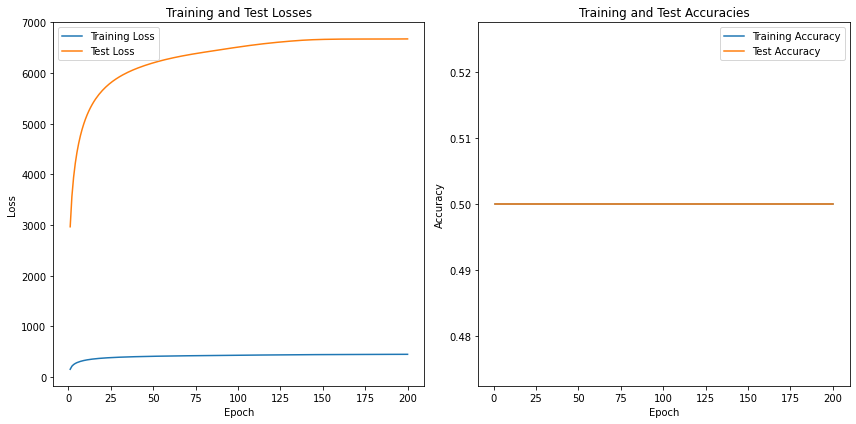

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Define activation functions and their derivatives
def leaky_relu(x):
    return np.maximum(0.1 * x, x)

def leaky_relu_derivative(x):
    dx = np.ones_like(x)
    dx[x < 0] *= 0.1
    return dx

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Initialize weights using He initialization
def he_init(input_size, output_size):
    return np.random.randn(input_size, output_size) * np.sqrt(2.0 / input_size)

# Initialize lists to store training and test losses
train_losses = []
test_losses = []

# Initialize lists to store training and test accuracies
train_accuracies = []
test_accuracies = []

X_train = train_x
X_test = test_x
y_train = train_y
y_test = test_y

# Neural Network Parameters
input_size = 784
hidden_size1 = 64
hidden_size2 = 32
hidden_size3 = 16
output_size = 1  
learning_rate = 0.01
epochs = 200
l2_lambda = 0.01  # L2 regularization parameter

# Initialize weights and biases
W1 = he_init(input_size, hidden_size1)
b1 = he_init(1, hidden_size1)
W2 = he_init(hidden_size1, hidden_size2)
b2 = he_init(1, hidden_size2)
W3 = he_init(hidden_size2, hidden_size3)
b3 = he_init(1, hidden_size3)
W4 = he_init(hidden_size3, output_size)
b4 = he_init(1, output_size)

batch_size = 64
epsilon = 1e-8
beta1_adam = 0.9  # Decay rate for the first moment estimate in Adam
beta2_adam = 0.999  # Decay rate for the second moment estimate in Adam

# Batch normalization parameters
gamma1 = np.ones((1, hidden_size1))
beta1_bn = np.zeros((1, hidden_size1))
gamma2 = np.ones((1, hidden_size2))
beta2_bn = np.zeros((1, hidden_size2))
gamma3 = np.ones((1, hidden_size3))
beta3_bn = np.zeros((1, hidden_size3))
gamma4 = np.ones((1, output_size))
beta4_bn = np.zeros((1, output_size))

# Initialize moment estimates for Adam
m_W1, m_b1 = 0, 0
m_W2, m_b2 = 0, 0
m_W3, m_b3 = 0, 0
m_W4, m_b4 = 0, 0
v_W1, v_b1 = 0, 0
v_W2, v_b2 = 0, 0
v_W3, v_b3 = 0, 0
v_W4, v_b4 = 0, 0

# Training loop
for epoch in range(epochs):
    total_loss = 0.0  # Initialize total loss for the epoch
    for i in range(0, len(X_train), batch_size):
        # Forward propagation
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        z1 = np.dot(X_batch, W1) + b1
        z1_norm = (z1 - np.mean(z1, axis=0)) / np.sqrt(np.var(z1, axis=0) + epsilon)
        a1 = leaky_relu(gamma1 * z1_norm + beta1_bn)

        z2 = np.dot(a1, W2) + b2
        z2_norm = (z2 - np.mean(z2, axis=0)) / np.sqrt(np.var(z2, axis=0) + epsilon)
        a2 = leaky_relu(gamma2 * z2_norm + beta2_bn)
        
        z3 = np.dot(a2, W3) + b3
        z3_norm = (z3 - np.mean(z3, axis=0)) / np.sqrt(np.var(z3, axis=0) + epsilon)
        a3 = leaky_relu(gamma3 * z3_norm + beta3_bn)

        z4 = np.dot(a3, W4) + b4
        z4_norm = (z4 - np.mean(z4, axis=0)) / np.sqrt(np.var(z4, axis=0) + epsilon)
        z4_clipped = np.clip(z4_norm, -500, 500)  # Clip values to prevent overflow
        a4 = sigmoid(gamma4 * z4_clipped + beta4_bn)
        
        # Backpropagation
        delta4 = (a4 - y_batch.reshape(-1, 1)) * sigmoid_derivative(a4)
        dW4 = np.dot(a3.T, delta4) + l2_lambda * W4
        db4 = np.sum(delta4, axis=0, keepdims=True)
        delta3 = np.dot(delta4, W4.T) * leaky_relu_derivative(z3)
        dW3 = np.dot(a2.T, delta3) + l2_lambda * W3
        db3 = np.sum(delta3, axis=0)

        delta2 = np.dot(delta3, W3.T) * leaky_relu_derivative(z2)
        dW2 = np.dot(a1.T, delta2) + l2_lambda * W2
        db2 = np.sum(delta2, axis=0)

        delta1 = np.dot(delta2, W2.T) * leaky_relu_derivative(z1)
        dW1 = np.dot(X_batch.T, delta1) + l2_lambda * W1
        db1 = np.sum(delta1, axis=0)

        # Calculate loss for the current batch
        batch_loss = -np.sum(y_batch * np.log(a4) + (1 - y_batch) * np.log(1 - a4)) / len(X_batch)
        total_loss += batch_loss

        # Update moment estimates for Adam
        m_W4 = beta1_adam * m_W4 + (1 - beta1_adam) * dW4
        m_b4 = beta1_adam * m_b4 + (1 - beta1_adam) * db4
        v_W4 = beta2_adam * v_W4 + (1 - beta2_adam) * (dW4 ** 2)
        v_b4 = beta2_adam * v_b4 + (1 - beta2_adam) * (db4 ** 2)
        m_W3 = beta1_adam * m_W3 + (1 - beta1_adam) * dW3
        m_b3 = beta1_adam * m_b3 + (1 - beta1_adam) * db3
        v_W3 = beta2_adam * v_W3 + (1 - beta2_adam) * (dW3 ** 2)
        v_b3 = beta2_adam * v_b3 + (1 - beta2_adam) * (db3 ** 2)
        m_W2 = beta1_adam * m_W2 + (1 - beta1_adam) * dW2
        m_b2 = beta1_adam * m_b2 + (1 - beta1_adam) * db2
        v_W2 = beta2_adam * v_W2 + (1 - beta2_adam) * (dW2 ** 2)
        v_b2 = beta2_adam * v_b2 + (1 - beta2_adam) * (db2 ** 2)
        m_W1 = beta1_adam * m_W1 + (1 - beta1_adam) * dW1
        m_b1 = beta1_adam * m_b1 + (1 - beta1_adam) * db1
        v_W1 = beta2_adam * v_W1 + (1 - beta2_adam) * (dW1 ** 2)
        v_b1 = beta2_adam * v_b1 + (1 - beta2_adam) * (db1 ** 2)

        # Bias correction for moment estimates
        m_W4_corrected = m_W4 / (1 - beta1_adam ** (epoch + 1))
        m_b4_corrected = m_b4 / (1 - beta1_adam ** (epoch + 1))
        v_W4_corrected = v_W4 / (1 - beta2_adam ** (epoch + 1))
        v_b4_corrected = v_b4 / (1 - beta2_adam ** (epoch + 1))
        m_W3_corrected = m_W3 / (1 - beta1_adam ** (epoch + 1))
        m_b3_corrected = m_b3 / (1 - beta1_adam ** (epoch + 1))
        v_W3_corrected = v_W3 / (1 - beta2_adam ** (epoch + 1))
        v_b3_corrected = v_b3 / (1 - beta2_adam ** (epoch + 1))
        m_W2_corrected = m_W2 / (1 - beta1_adam ** (epoch + 1))
        m_b2_corrected = m_b2 / (1 - beta1_adam ** (epoch + 1))
        v_W2_corrected = v_W2 / (1 - beta2_adam ** (epoch + 1))
        v_b2_corrected = v_b2 / (1 - beta2_adam ** (epoch + 1))
        m_W1_corrected = m_W1 / (1 - beta1_adam ** (epoch + 1))
        m_b1_corrected = m_b1 / (1 - beta1_adam ** (epoch + 1))
        v_W1_corrected = v_W1 / (1 - beta2_adam ** (epoch + 1))
        v_b1_corrected = v_b1 / (1 - beta2_adam ** (epoch + 1))

        # Update weights and biases using Adam with bias correction
        W1 -= learning_rate * m_W1_corrected / (np.sqrt(v_W1_corrected) + epsilon)
        b1 -= learning_rate * m_b1_corrected / (np.sqrt(v_b1_corrected) + epsilon)
        W2 -= learning_rate * m_W2_corrected / (np.sqrt(v_W2_corrected) + epsilon)
        b2 -= learning_rate * m_b2_corrected / (np.sqrt(v_b2_corrected) + epsilon)
        W3 -= learning_rate * m_W3_corrected / (np.sqrt(v_W3_corrected) + epsilon)
        b3 -= learning_rate * m_b3_corrected / (np.sqrt(v_b3_corrected) + epsilon)
        W4 -= learning_rate * m_W4_corrected / (np.sqrt(v_W4_corrected) + epsilon)
        b4 -= learning_rate * m_b4_corrected / (np.sqrt(v_b4_corrected) + epsilon)

        # Update batch normalization parameters
        gamma1 -= learning_rate * np.sum(delta1 * z1_norm, axis=0)
        beta1_bn -= learning_rate * np.sum(delta1, axis=0)
        gamma2 -= learning_rate * np.sum(delta2 * z2_norm, axis=0)
        beta2_bn -= learning_rate * np.sum(delta2, axis=0)
        gamma3 -= learning_rate * np.sum(delta3 * z3_norm, axis=0)
        beta3_bn -= learning_rate * np.sum(delta3, axis=0)
        gamma4 -= learning_rate * np.sum(delta4 * z4_norm, axis=0)
        beta4_bn -= learning_rate * np.sum(delta4, axis=0)
        
        # Calculate loss for the current batch and add it to the total loss for the epoch
        batch_loss = -np.sum(y_batch * np.log(a4) + (1 - y_batch) * np.log(1 - a4)) / len(X_batch)
        total_loss += batch_loss
    
    # Average loss over all batches for the epoch
    avg_loss = total_loss / (len(X_train) / batch_size)
    train_losses.append(avg_loss)  # Store training loss for the epoch
    
    z1 = np.dot(X_train, W1) + b1
    a1 = leaky_relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = leaky_relu(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = leaky_relu(z3)
    z4 = np.dot(a3, W4) + b4
    a4_train = sigmoid(z4)
    
    # Calculate training accuracy for the epoch
    train_predictions = (a4_train > 0.5).astype(int)
    train_accuracy = np.mean(train_predictions == y_train)
    train_accuracies.append(train_accuracy)  # Store training accuracy for the epoch

    # Testing
    z1 = np.dot(X_test, W1) + b1
    a1 = leaky_relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = leaky_relu(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = leaky_relu(z3)
    z4 = np.dot(a3, W4) + b4
    z4_norm = (z4 - np.mean(z4, axis=0)) / np.sqrt(np.var(z4, axis=0) + epsilon)
    z4_clipped = np.clip(z4_norm, -500, 500)  # Clip values to prevent overflow
    a4 = sigmoid(gamma4 * z4_clipped + beta4_bn)


    # Calculate test loss
    test_loss = -np.sum(y_test * np.log(a4) + (1 - y_test) * np.log(1 - a4)) / (len(X_test) + epsilon)
    test_losses.append(test_loss)  # Store test loss for the epoch
    
    # Calculate test accuracy
    test_predictions = (a4 > 0.5).astype(int)
    test_accuracy = np.mean(test_predictions == y_test)
    test_accuracies.append(test_accuracy)  # Store test accuracy for the epoch

    # Print average loss for the epoch
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')

# Plotting
plt.figure(figsize=(12, 6))

# Plot training and test losses
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

# Plot training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies')
plt.legend()

plt.tight_layout()
plt.show()